# Description

This notebook explores ways to calculate share of remote work for each user in each month when their home and work location are known. As all data is big, only users that we meet at least 6 months in the dataset are included

In [1]:
import os
import geopandas as gpd
import pandas as pd
import argparse
from geofunctions import utils

## Read files

In [2]:
df_freq_ident = pd.read_csv(
    utils.get_path("processed", "dwells", "samples/identifiers_12m_freq.csv"), index_col=0
)

In [3]:
freq_users_list = df_freq_ident["identifier"].values

In [4]:
months = utils.return_list_months_ok()

In [ ]:
# Read files

list_months = []
for MONTH in months:
    print(MONTH)
    df_filtered_good = pd.read_parquet(
        utils.get_path("raw", "dwells", f"data_filtered_{MONTH}.parquet")
    )
    df_filtered_freq = df_filtered_good[
        df_filtered_good.identifier.isin(freq_users_list)
    ]
    if len(df_filtered_freq) > 0:
        df_filtered_dwells = utils.make_gdf(df_filtered_freq, geometry="the_geom")
        df_filtered_dwells["month"] = MONTH
        list_months.append(df_filtered_dwells)

In [5]:
df_filtered_dwells = pd.concat(list_months)

In [13]:
df_filtered_dwells.shape

(1558038, 22)

In [ ]:
list_freq_ident_df = []
for MONTH in months:

    work_df_part = pd.read_csv(
        os.path.join(
            utils.get_path("processed", "dwells", "work"),
            f"users_work_home_{MONTH}.csv",
        ),
        index_col=0,
    )
    freq_df = work_df_part[work_df_part.identifier.isin(freq_users_list)]
    freq_df["month"] = MONTH
    list_freq_ident_df.append(freq_df)

In [7]:
df_freq_home_work = pd.concat(list_freq_ident_df)

In [ ]:
df_freq_home_work = df_freq_home_work.drop_duplicates(["identifier", "month"])

## Add home/work location flags to dwells dataset

In [ ]:
df_freq_full_home_work = df_filtered_dwells.merge(
    df_freq_home_work[["identifier", "geohash_home", "geohash_work", "month"]],
    on=["identifier", "month"],
)

In [ ]:
df_freq_full_home_work["geometry_work"] = df_freq_full_home_work["geohash_work"].apply(
    utils.geohash_to_polygon
)
df_freq_full_home_work["distance_work"] = utils.calculate_distance(
    df_freq_full_home_work, "geometry_work", "the_geom", crs=4326
)

df_freq_full_home_work["flag_work_geohash"] = (
    df_freq_full_home_work["distance_work"] <= 250
)

In [ ]:
df_freq_full_home_work["geometry_home"] = df_freq_full_home_work["geohash_home"].apply(
    utils.geohash_to_polygon
)
df_freq_full_home_work["distance_home"] = utils.calculate_distance(
    df_freq_full_home_work, "geometry_home", "the_geom", crs=4326
)

df_freq_full_home_work["flag_home_geohash"] = (
    df_freq_full_home_work["distance_home"] <= 250
)

In [ ]:
df_freq_full_home_work["flag_type_loc_new"] = df_freq_full_home_work[
    ["flag_home_geohash", "flag_work_geohash"]
].apply(
    lambda r: (
        "home"
        if r["flag_home_geohash"]
        else ("work" if r["flag_work_geohash"] else "other")
    ),
    axis=1,
)

In [ ]:
df_freq_only_homework = df_freq_full_home_work[
    df_freq_full_home_work["flag_type_loc_new"].isin(["home", "work"])
]

In [25]:
df_freq_only_homework.shape

(885221, 31)

In [14]:
# explode dwells to hourly signals
df_freq_only_homework["hours_in_interval"] = df_freq_only_homework.apply(
    lambda row: pd.date_range(
        start=row["start_date_time"].floor("h"),
        end=row["end_date_time"].ceil("h") - pd.Timedelta(hours=1),
        freq="h",
    ).tolist(),
    axis=1,
)

# Explode the hours into separate rows
df_hours = df_freq_only_homework.explode("hours_in_interval")
df_hours["hour"] = df_hours["hours_in_interval"].dt.hour

In [16]:
df_hours.columns

Index(['identifier', 'identifier_type', 'timestamp', 'local_date_time',
       'province', 'classification', 'duration_seconds', 'centroid_latitude',
       'centroid_longitude', 'bump_count', 'potential_start_time',
       'potential_end_time', 'month', 'the_geom', 'frequency',
       'duration_hours', 'geohash', 'date', 'start_date_time', 'end_date_time',
       'flag_night', 'flag_work_hours', 'geohash_home', 'geohash_work',
       'geometry_work', 'distance_work', 'flag_work_geohash', 'geometry_home',
       'distance_home', 'flag_home_geohash', 'flag_type_loc_new',
       'hours_in_interval', 'hour'],
      dtype='object')

## Add day type weekend or not

In [ ]:

import holidays

# Define Israeli holidays
israel_holidays = holidays.Israel()

# Ensure 'date' is in datetime format first
df_hours["date"] = pd.to_datetime(df_hours["date"])

# Create the 'flag_weekend' column
df_hours["flag_weekend"] = (
    df_hours["date"].dt.weekday.isin([4, 5]) |  # Check if Friday or Saturday
    df_hours["date"].dt.date.isin(israel_holidays)  # Check if it's an Israeli holiday
)

## Add day type by user:
1. work from office - there is a signal from office

In [ ]:
df_hours["work_location_hours"] = df_hours.groupby(["date", "identifier"])[
    "flag_work_geohash"
].transform("sum")

In [ ]:
df_hours["office_day"] = df_hours["work_location_hours"] > 0

In [ ]:
df_hours["office_day"].value_counts()

office_day
False    1124374
True      926521
Name: count, dtype: int64

### Remove duplicates caused by consequent dwells, one of which starts and another one ends at the same hour

In [ ]:
df_hours.drop_duplicates(["identifier", "hour", "date"]).shape

(1887367, 36)

In [45]:
df_hours.shape

(2050895, 36)

In [ ]:
df_hours = df_hours.drop_duplicates(["identifier", "hour", "date"])

# Lets explore hours frequency when people work from office

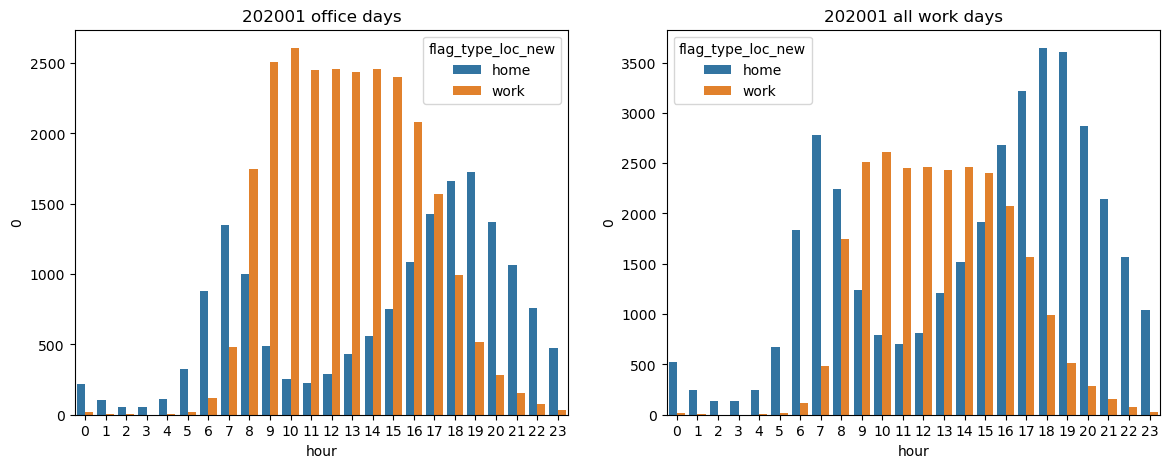

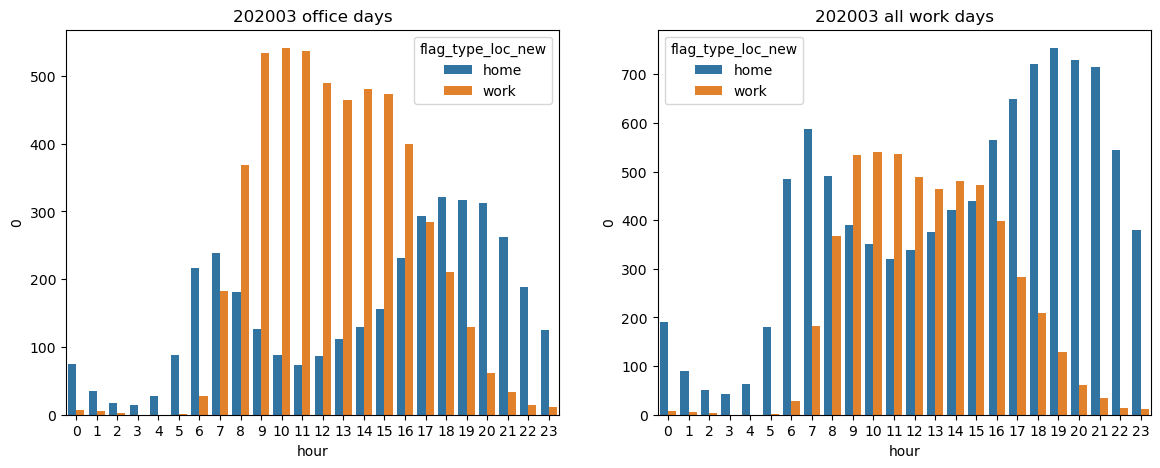

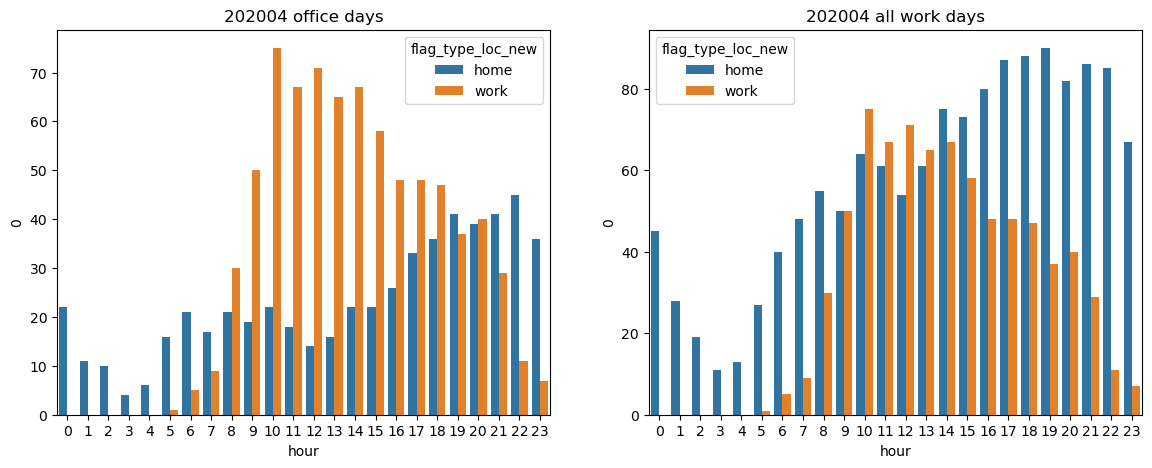

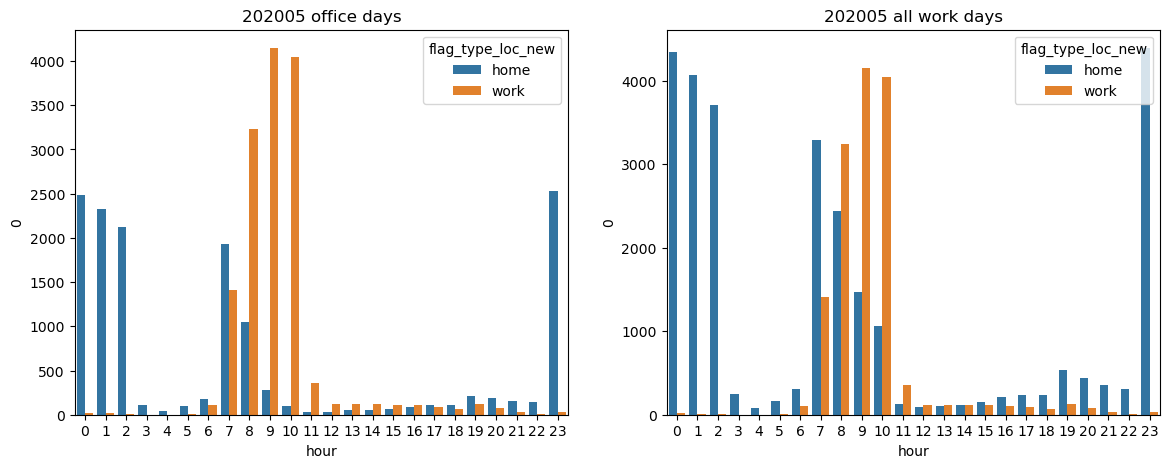

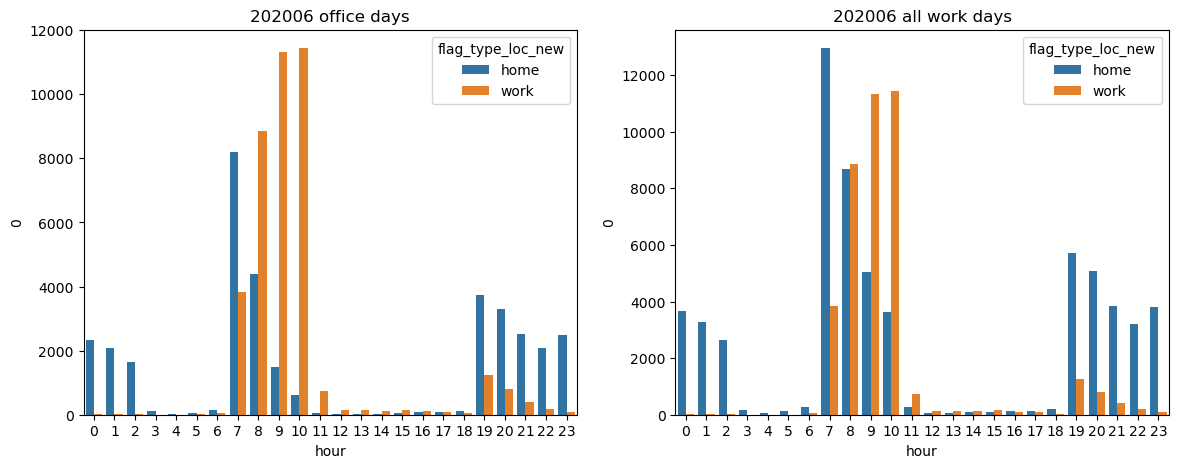

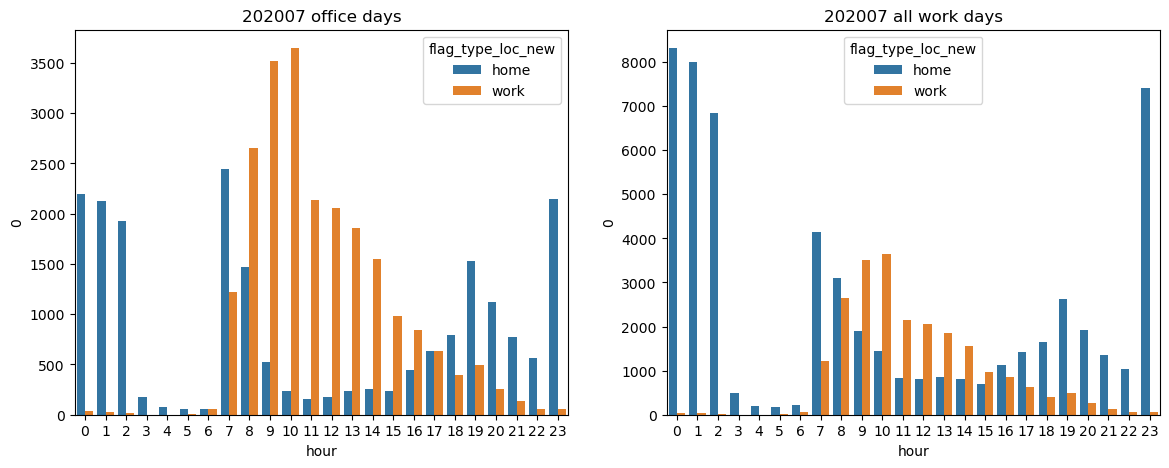

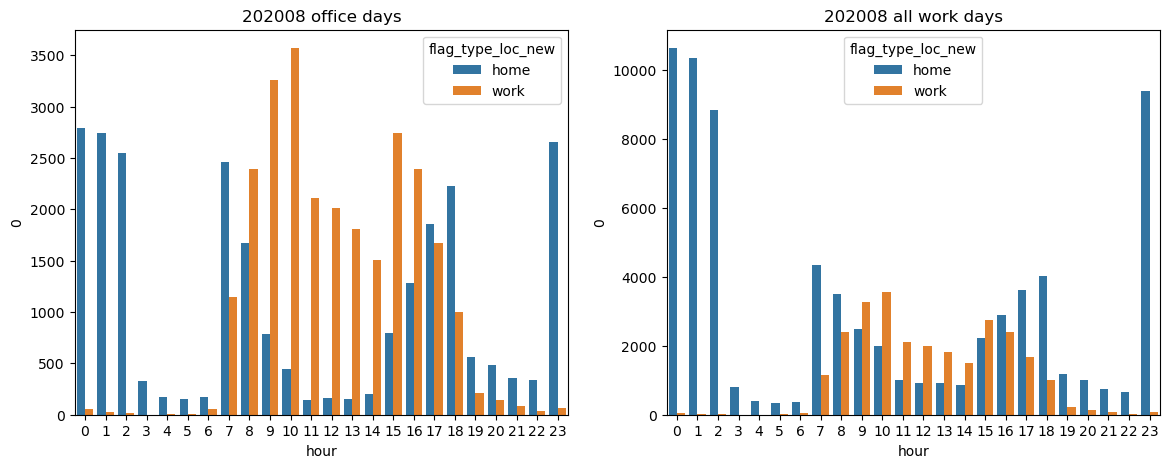

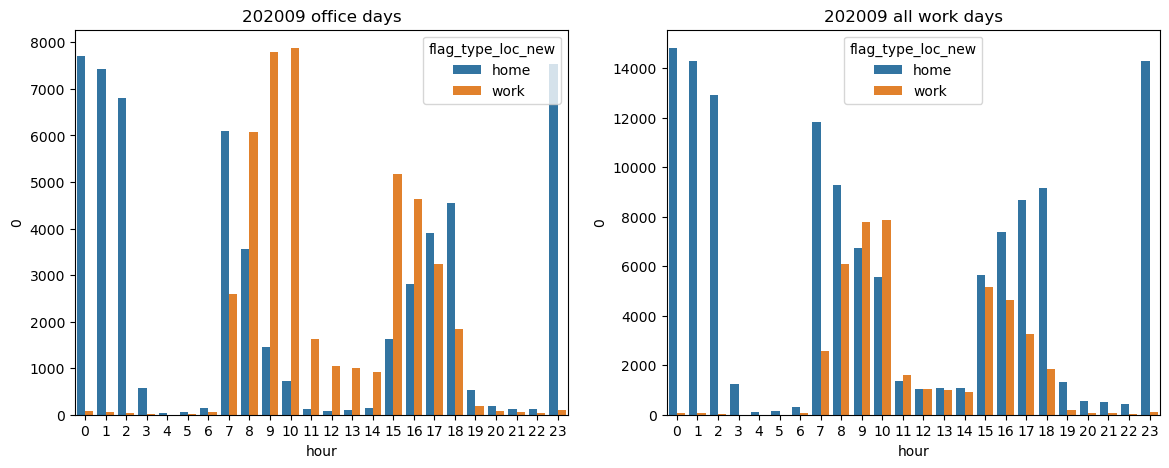

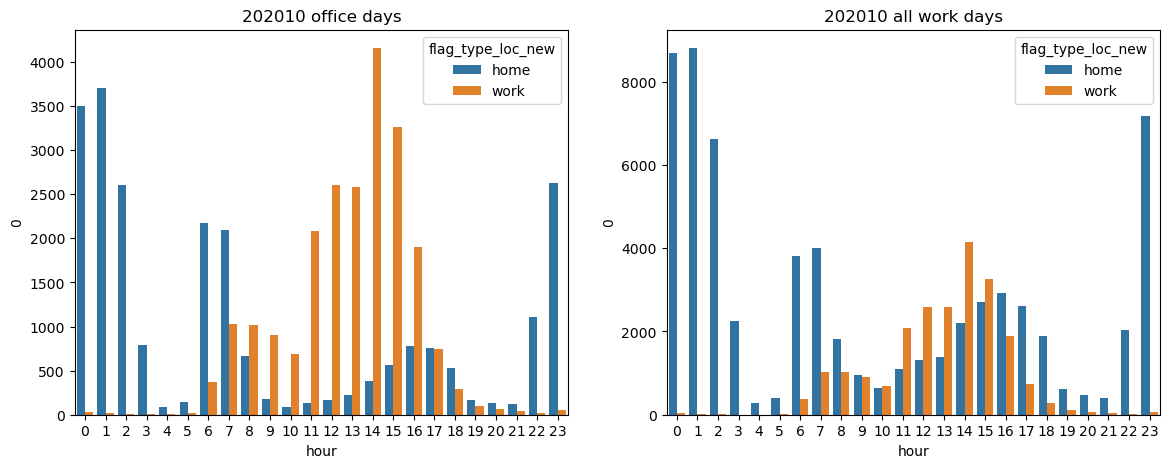

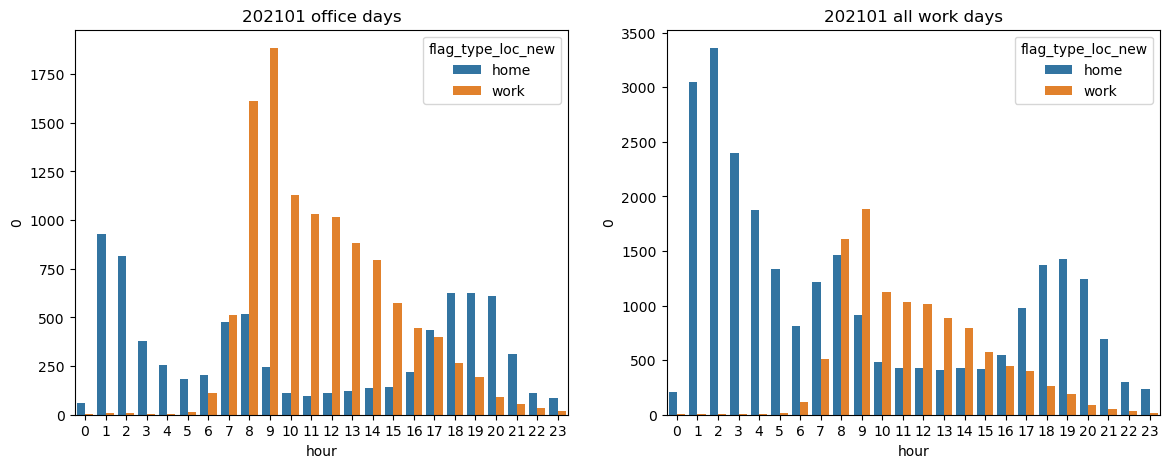

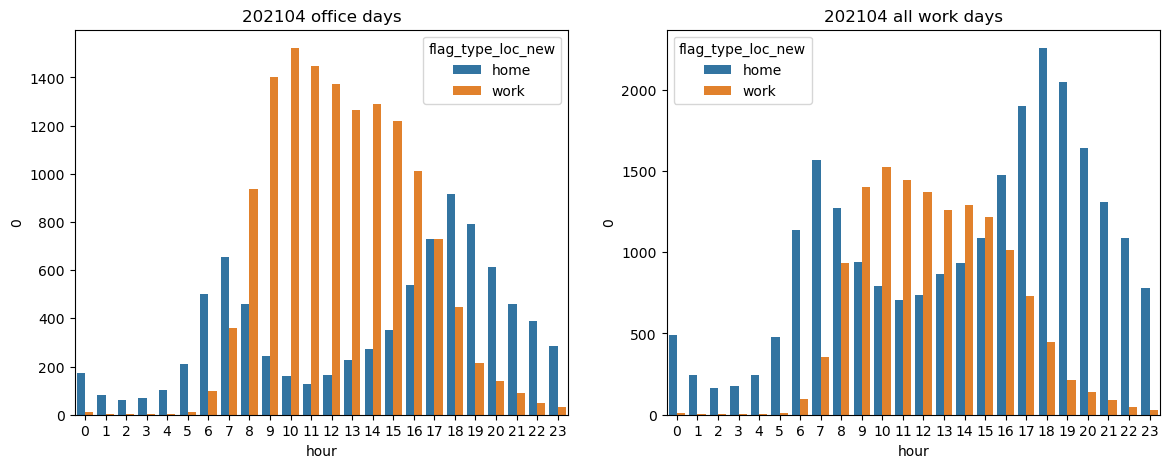

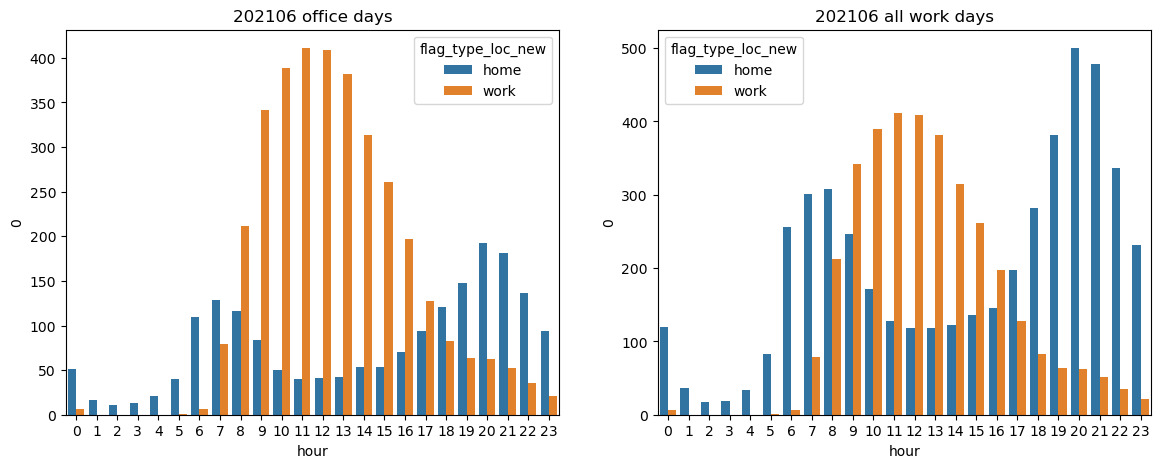

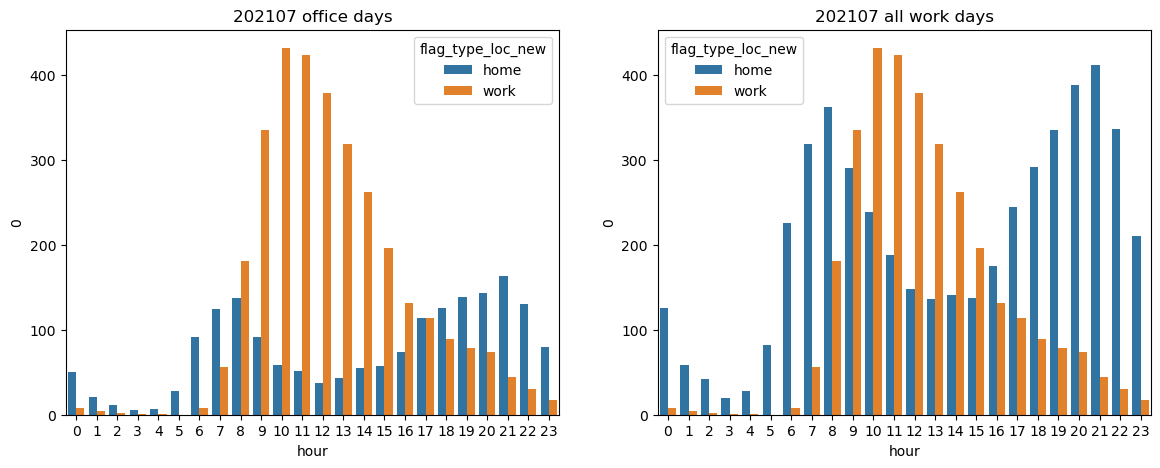

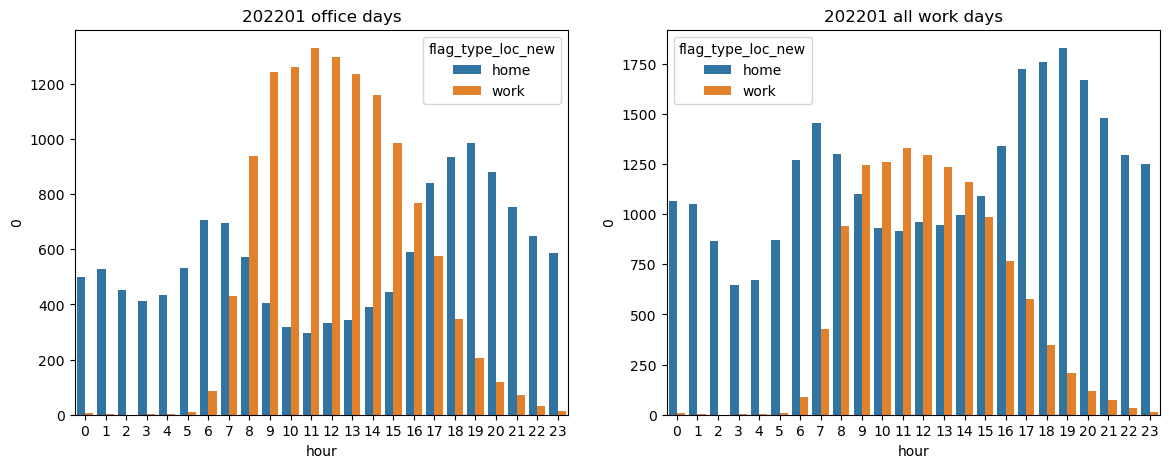

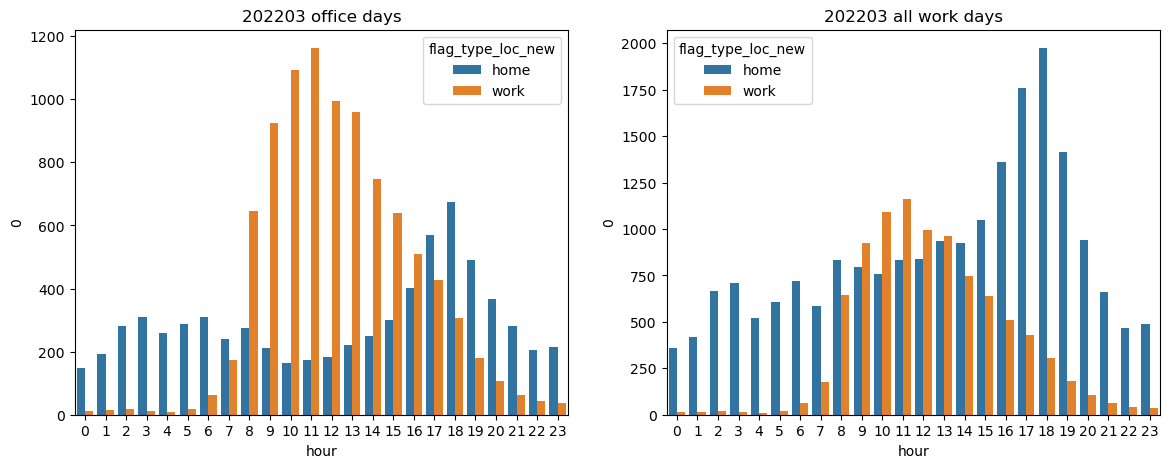

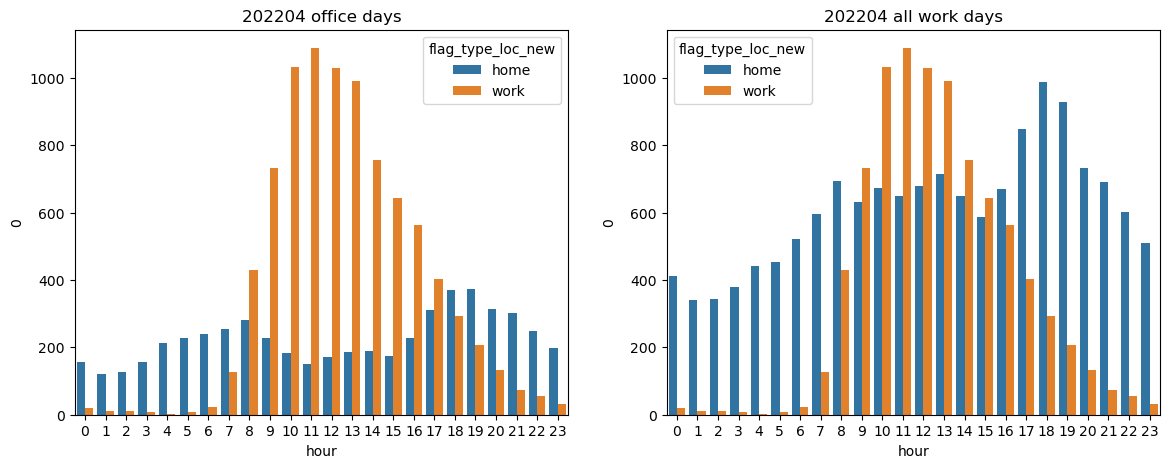

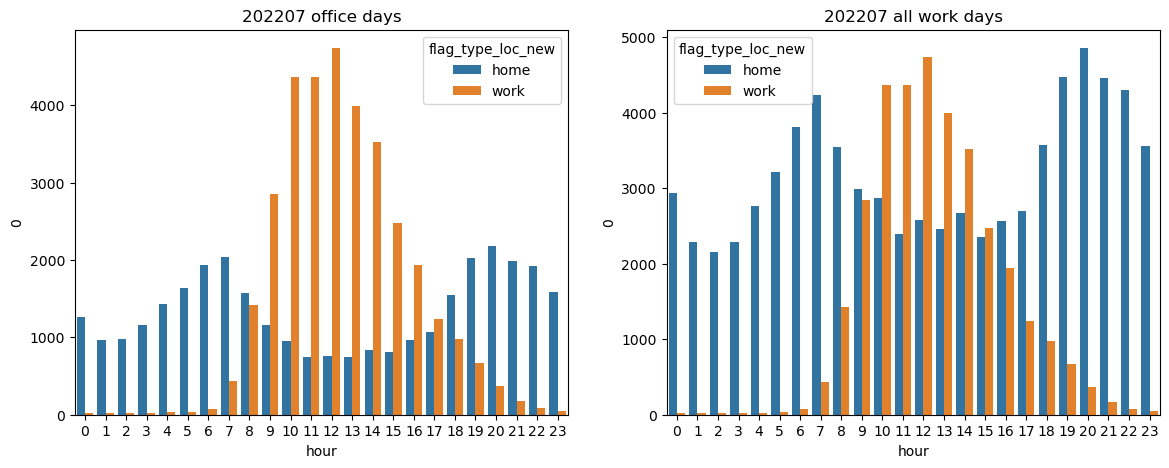

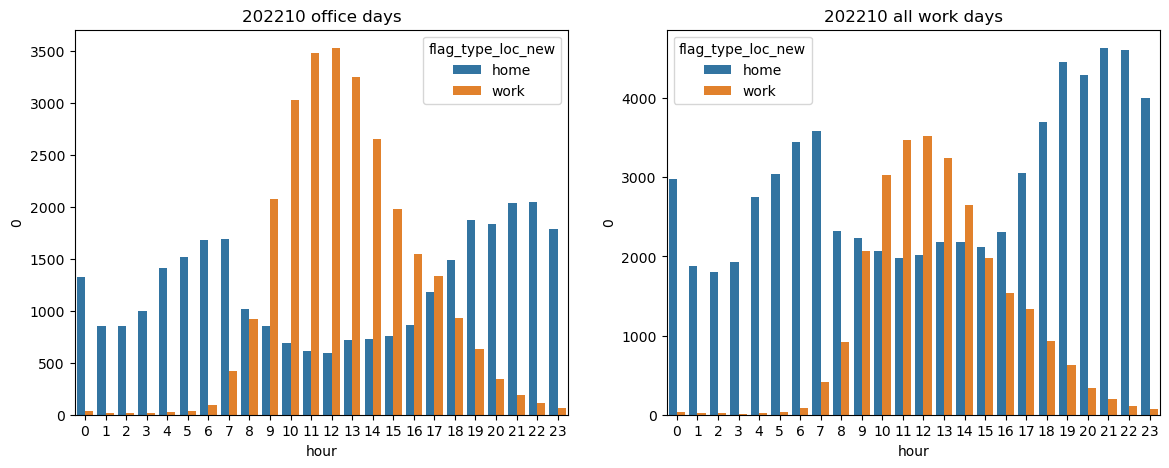

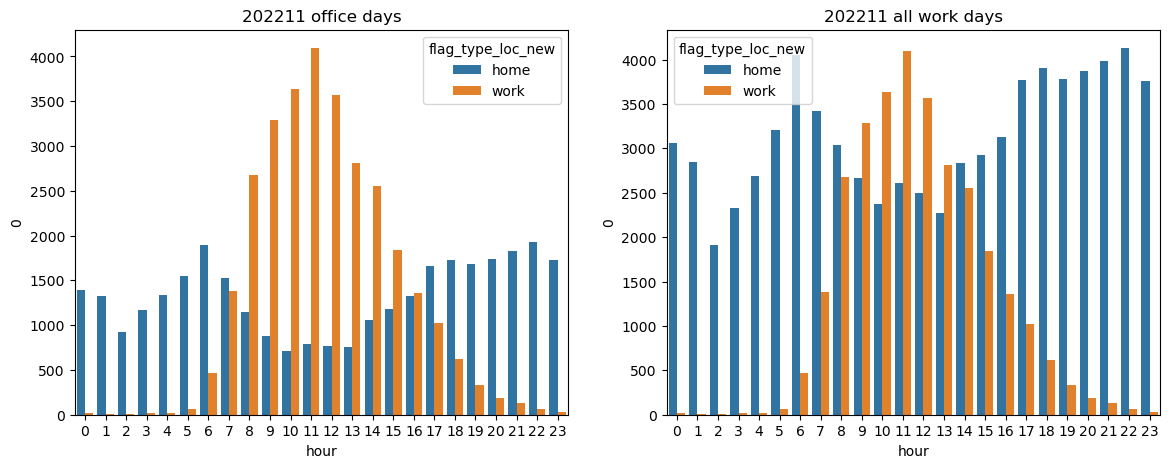

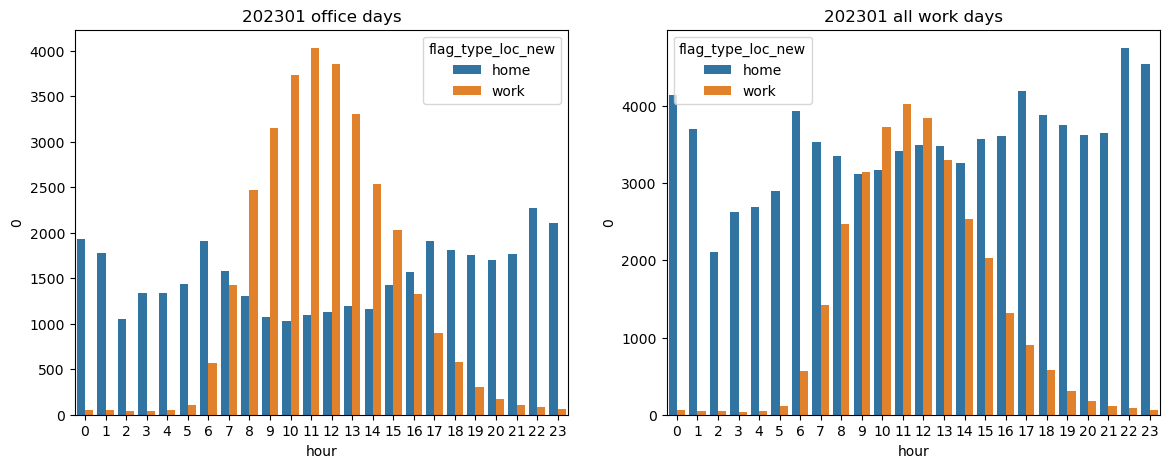

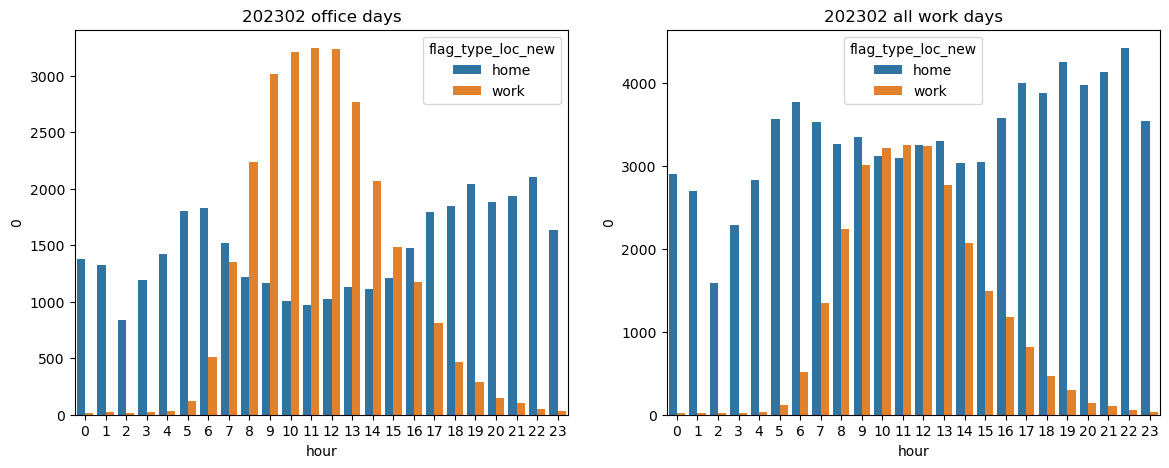

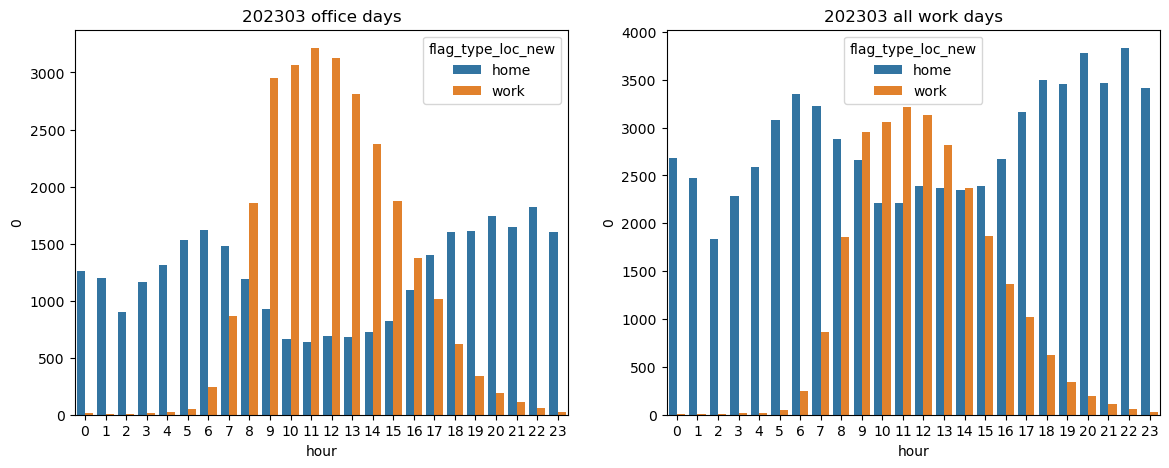

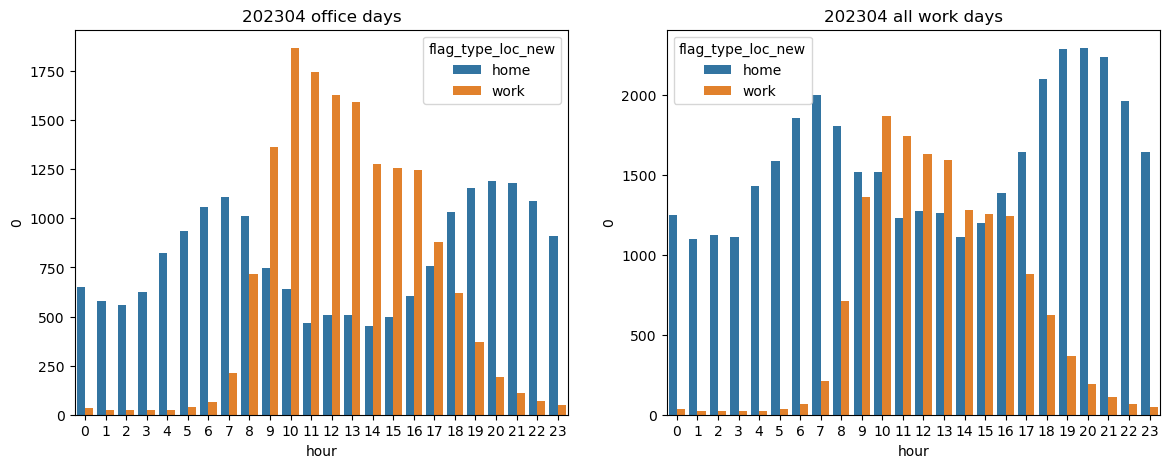

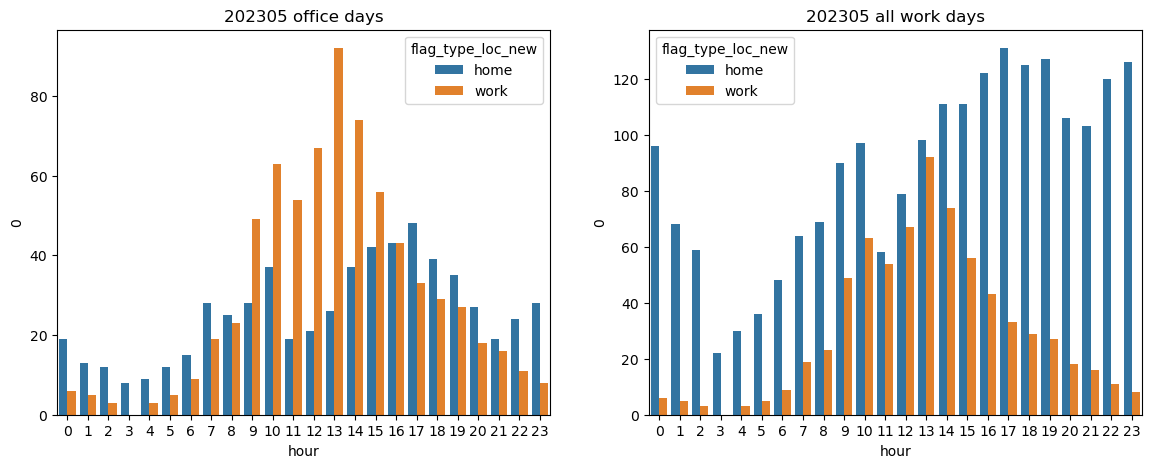

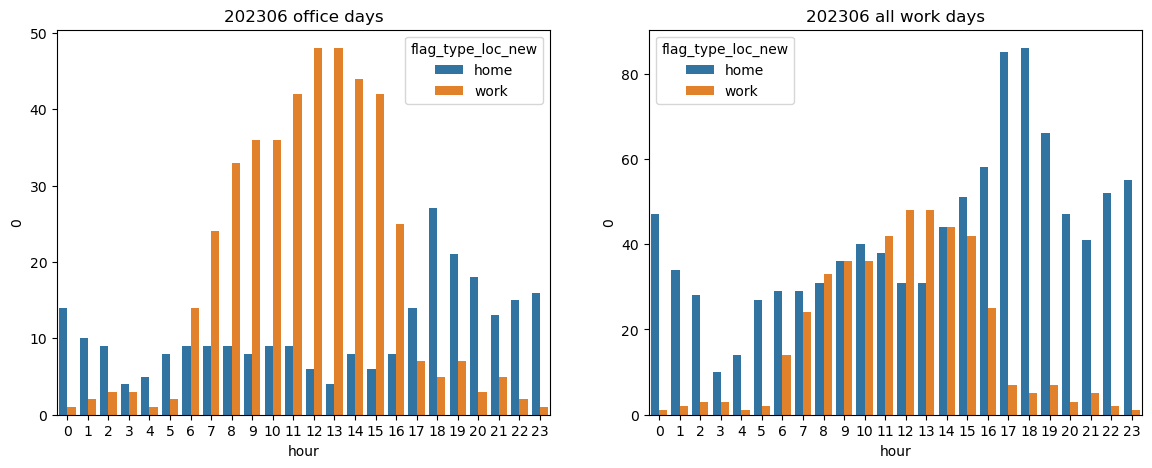

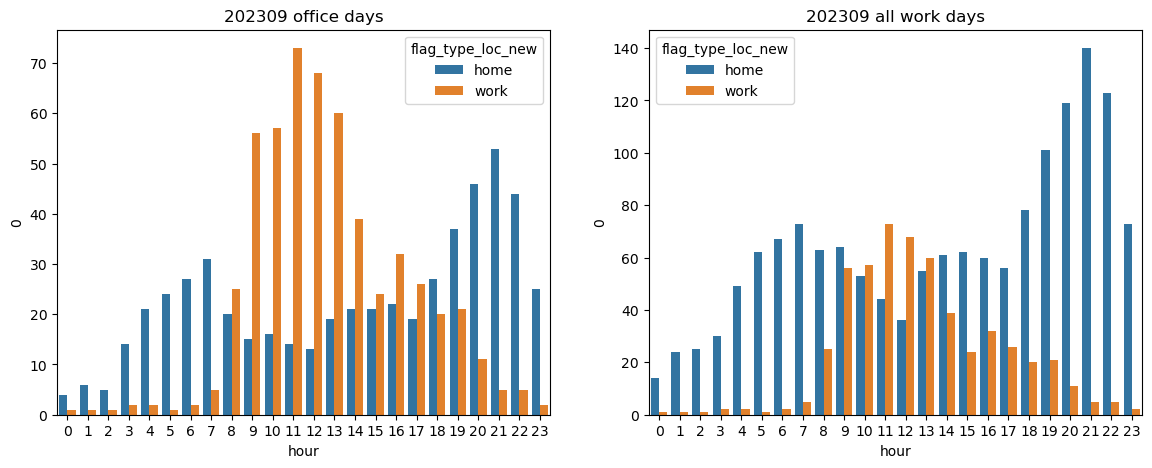

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn

for MONTH in months:
    df_month_loc_hours_office = (
        df_hours[
            (df_hours.month == MONTH)
            & (df_hours["office_day"])
            & (~df_hours.flag_weekend)
        ]
        .groupby(["hour", "flag_type_loc_new"])
        .size()
        .reset_index()
    )
    df_month_loc_hours = (
        df_hours[(df_hours.month == MONTH) & (~df_hours.flag_weekend)]
        .groupby(["hour", "flag_type_loc_new"])
        .size()
        .reset_index()
    )
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    sn.barplot(
        data=df_month_loc_hours_office,
        x="hour",
        y=0,
        hue="flag_type_loc_new",
        ax=axs[0],
    )
    axs[1].set_title(f"{MONTH} all work days")
    sn.barplot(
        data=df_month_loc_hours, x="hour", y=0, hue="flag_type_loc_new", ax=axs[1]
    )
    axs[0].set_title(f"{MONTH} office days")
    plt.show()

In [ ]:
# Office day distribution of dwells for each user - is expected behavior when there is no WFH
# In the day where office hours are absent there are two options: no signals in work hours at all or he worked remotely

First we explore why some people have afternoon signals at home before covid. Apparently they have work shifts that dont match standart working hours

In [ ]:
df_month_loc_hours_office = df_hours[
    (df_hours.month == "202001") & (df_hours["office_day"]) & (~df_hours.flag_weekend)
]

In [ ]:
df_month_loc_hours_office[
    df_month_loc_hours_office.identifier == "7c1183ab-4bcb-419d-ab29-2b81fd9d7ab7"
].sort_values("hours_in_interval")[
    ["the_geom", "hours_in_interval", "flag_type_loc_new"]
].explore(
    column="flag_type_loc_new"
)

In [ ]:
df_month_loc_hours_office[
    (df_month_loc_hours_office.hour < 17)
    & (df_month_loc_hours_office.hour > 9)
    & (df_month_loc_hours_office.flag_home_geohash)
]

,identifier,identifier_type,timestamp,local_date_time,province,classification,duration_seconds,centroid_latitude,centroid_longitude,bump_count,...,flag_work_geohash,geometry_home,distance_home,flag_home_geohash,flag_type_loc_new,hours_in_interval,hour,flag_weekend,work_location_hours,office_day
10,7c1183ab-4bcb-419d-ab29-2b81fd9d7ab7,IDFA,2020-01-01 11:25:40,2020-01-01 13:25:40,HaMerkaz,AREA_DWELL,4884.0,32.274596,34.886819,6,...,False,POLYGON ((34.885711669921875 32.27371215820312...,0.000000,True,home,2020-01-01 13:00:00,13,False,7,True
10,7c1183ab-4bcb-419d-ab29-2b81fd9d7ab7,IDFA,2020-01-01 11:25:40,2020-01-01 13:25:40,HaMerkaz,AREA_DWELL,4884.0,32.274596,34.886819,6,...,False,POLYGON ((34.885711669921875 32.27371215820312...,0.000000,True,home,2020-01-01 14:00:00,14,False,7,True
88,3d4721e1-0c5f-4220-83b8-19445acbf391,GAID,2020-01-15 10:30:12,2020-01-15 12:30:12,HaMerkaz,AREA_DWELL,2416.0,32.104613,34.879436,7,...,False,POLYGON ((34.87884521484375 32.103424072265625...,0.000000,True,home,2020-01-15 12:00:00,12,False,4,True
88,3d4721e1-0c5f-4220-83b8-19445acbf391,GAID,2020-01-15 10:30:12,2020-01-15 12:30:12,HaMerkaz,AREA_DWELL,2416.0,32.104613,34.879436,7,...,False,POLYGON ((34.87884521484375 32.103424072265625...,0.000000,True,home,2020-01-15 13:00:00,13,False,4,True
99,7941a843-4472-42d2-99c8-966bd3138caa,GAID,2020-01-21 08:03:31,2020-01-21 10:03:31,HaMerkaz,AREA_DWELL,8379.0,31.878706,34.809158,11,...,False,POLYGON ((34.808807373046875 31.87820434570312...,0.000000,True,home,2020-01-21 10:00:00,10,False,3,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77750,9adab8b1-5ec3-4f68-b734-06c142a6da17,IDFA,2020-01-14 09:37:31,2020-01-14 11:37:31,Tel Aviv,AREA_DWELL,2232.0,32.013267,34.772007,11,...,False,"POLYGON ((34.771728515625 32.012786865234375, ...",0.000000,True,home,2020-01-14 12:00:00,12,False,2,True
77778,c091c167-f013-4b00-be2f-fa6b07fad545,GAID,2020-01-08 12:10:21,2020-01-08 14:10:21,Tel Aviv,AREA_DWELL,4061.0,32.120615,34.835831,13,...,False,POLYGON ((34.83489990234375 32.119903564453125...,0.000000,True,home,2020-01-08 14:00:00,14,False,1,True
77778,c091c167-f013-4b00-be2f-fa6b07fad545,GAID,2020-01-08 12:10:21,2020-01-08 14:10:21,Tel Aviv,AREA_DWELL,4061.0,32.120615,34.835831,13,...,False,POLYGON ((34.83489990234375 32.119903564453125...,0.000000,True,home,2020-01-08 15:00:00,15,False,1,True
77813,1c2372bb-61ed-4338-9ad4-a3897823071f,GAID,2020-01-07 13:09:00,2020-01-07 15:09:00,Tel Aviv,AREA_DWELL,13515.0,32.064529,34.771786,20,...,False,"POLYGON ((34.770355224609375 32.0635986328125,...",5.390959,True,home,2020-01-07 15:00:00,15,False,4,True


In [ ]:
df_month_loc_hours_office[
    df_month_loc_hours_office["identifier"] == "3d4721e1-0c5f-4220-83b8-19445acbf391"
].sort_values("hours_in_interval")[["hours_in_interval", "flag_type_loc_new"]]

,hours_in_interval,flag_type_loc_new
40687,2020-01-07 08:00:00,work
40687,2020-01-07 09:00:00,work
40687,2020-01-07 10:00:00,work
40687,2020-01-07 11:00:00,work
33350,2020-01-07 18:00:00,home
33350,2020-01-07 19:00:00,home
62789,2020-01-07 20:00:00,home
62789,2020-01-07 21:00:00,home
16171,2020-01-14 08:00:00,work
16171,2020-01-14 09:00:00,work


## Approaches to remote working

1st. For each day of the month and for each user I identify the type of the day: office/ remote/ unknown

In [ ]:
#improved hours after doing conditional probability
df_hours["flag_work_hour"] = (~df_hours["flag_weekend"]) & (
    df_hours["hour"].apply(lambda x: (x <= 20) & (x >= 8))
)
df_hours["flag_work_hours_day"] = (
    df_hours.groupby(["identifier", "date"])["flag_work_hour"].transform("sum") > 0
)

In [426]:
df_user_days = (
    df_hours.groupby(["identifier", "date", "month"])[
        ["flag_work_hours_day", "flag_weekend", "office_day"]
    ]
    .mean()
    .reset_index()
)

In [ ]:
df_user_days["day_type"] = df_user_days[
    ["flag_work_hours_day", "flag_weekend", "office_day"]
].apply(
    lambda r: (
        "office"
        if r["office_day"] == 1
        else (
            "remote"
            if (r["flag_work_hours_day"] > 0) and (not r["flag_weekend"])
            else ("weekend" if r["flag_weekend"] else "unknown")
        )
    ),
    axis=1,
)

In [ ]:
df_days_types = (
    df_user_days.groupby(["month", "day_type"]).size().rename("day_count").reset_index()
)

In [80]:
df_days_types.day_type.value_counts()

day_type
office     26
remote     26
unknown    26
weekend    26
Name: count, dtype: int64

In [ ]:
months = df_days_types["month"].unique()
day_types = df_days_types["day_type"].unique()

# Create a complete DataFrame with all combinations of months and day types
full_combinations = pd.MultiIndex.from_product(
    [months, day_types], names=["month", "day_type"]
)
full_df = pd.DataFrame(index=full_combinations).reset_index()
df_days_types_complete = full_df.merge(
    df_days_types, on=["month", "day_type"], how="left"
).fillna({"day_count": 0})

In [ ]:
df_days_types_complete["day_count"] = df_days_types_complete["day_count"].astype(int)

In [82]:
df_days_types_complete.isnull().mean()

month        0.0
day_type     0.0
day_count    0.0
dtype: float64

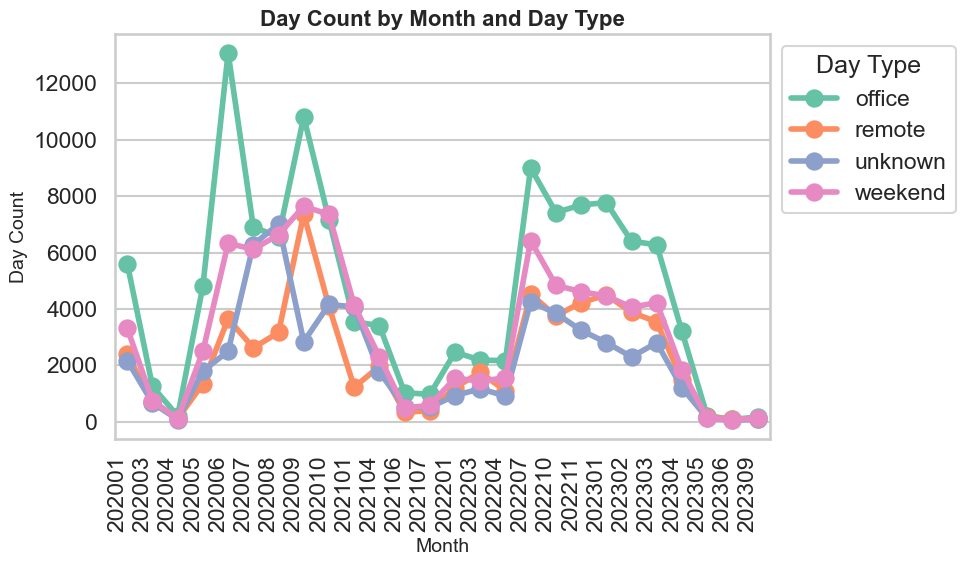

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

# Set the style and context
sn.set_theme(style="whitegrid", context="talk")


# Create the point plot with enhancements
plt.figure(figsize=(10, 6))
plot = sn.pointplot(
    data=df_days_types_complete,
    x="month",
    y="day_count",
    hue="day_type",
    palette="Set2",  # Vibrant color palette
)

# Customize labels and title
plot.set_title("Day Count by Month and Day Type", fontsize=16, weight="bold")
plot.set_xlabel("Month", fontsize=14)
plot.set_ylabel("Day Count", fontsize=14)

# Rotate x-axis labels for better readability
plot.set_xticklabels(
    plot.get_xticklabels(), rotation="vertical", horizontalalignment="right"
)

# Add legend and improve its placement
plot.legend(title="Day Type", loc="upper left", bbox_to_anchor=(1, 1))


# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Exclude rows where day_type is 'Weekend'
filtered_df = df_days_types_complete[df_days_types_complete["day_type"] != "weekend"]

# Calculate the total day count per month (excluding 'Weekend')
filtered_df["month_total"] = filtered_df.groupby("month")["day_count"].transform("sum")

# Calculate the share of day counts for each row
filtered_df["share_of_day_counts"] = (
    filtered_df["day_count"] / filtered_df["month_total"]
)

# Drop the temporary 'month_total' column if not needed
filtered_df = filtered_df.drop(columns=["month_total"])

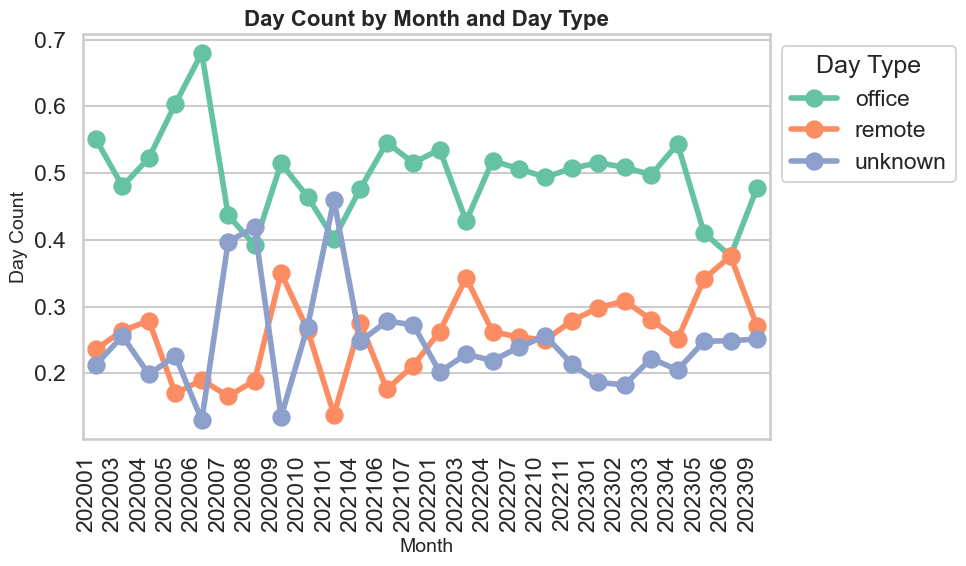

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

# Set the style and context
sn.set_theme(style="whitegrid", context="talk")


# Create the point plot with enhancements
plt.figure(figsize=(10, 6))
plot = sn.pointplot(
    data=filtered_df,
    x="month",
    y="share_of_day_counts",
    hue="day_type",
    palette="Set2",  # Vibrant color palette
)

# Customize labels and title
plot.set_title("Day Count by Month and Day Type", fontsize=16, weight="bold")
plot.set_xlabel("Month", fontsize=14)
plot.set_ylabel("Day Count", fontsize=14)

# Rotate x-axis labels for better readability
plot.set_xticklabels(
    plot.get_xticklabels(), rotation="vertical", horizontalalignment="right"
)

# Add legend and improve its placement
plot.legend(title="Day Type", loc="upper left", bbox_to_anchor=(1, 1))


# Display the plot
plt.tight_layout()
plt.show()

### Looks much better than before. Now instead of using exact time interval, I will use probability for each user to be at work location this hour based on their office days hours distribution

## Lets do it first fr one user

In [ ]:
ident = "35877402-7e02-48a2-a522-a9e7fe4699d8"

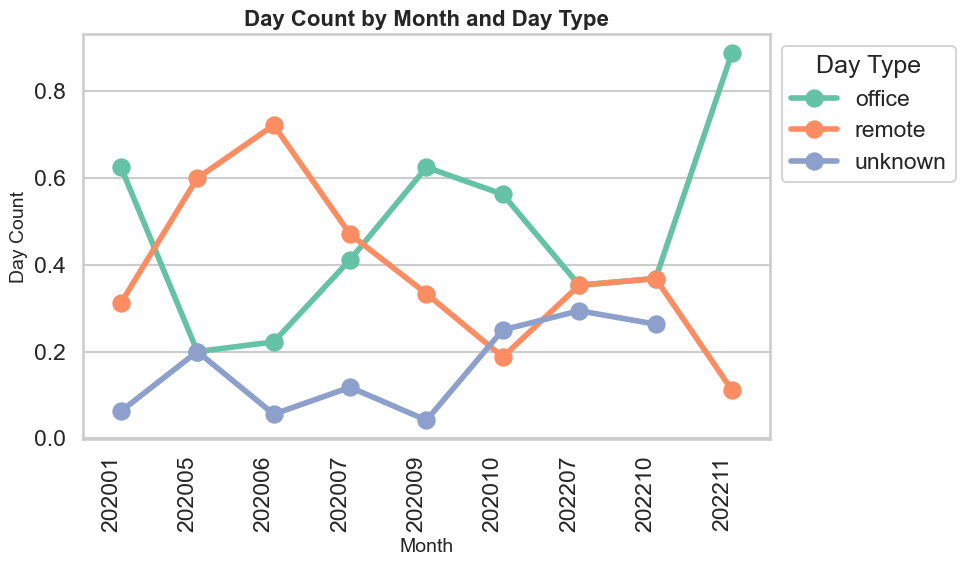

In [256]:
import seaborn as sn
import matplotlib.pyplot as plt

# Set the style and context
sn.set_theme(style="whitegrid", context="talk")

df_days_one_user = (
    df_user_days[df_user_days.identifier == ident]
    .groupby(["month", "day_type"])
    .size()
    .rename("day_count")
    .reset_index()
)
filtered_df = df_days_one_user[(df_days_one_user["day_type"] != "weekend")]

# Calculate the total day count per month (excluding 'Weekend')
filtered_df["month_total"] = filtered_df.groupby("month")["day_count"].transform("sum")

# Calculate the share of day counts for each row
filtered_df["share_of_day_counts"] = (
    filtered_df["day_count"] / filtered_df["month_total"]
)

# Drop the temporary 'month_total' column if not needed
filtered_df = filtered_df.drop(columns=["month_total"])

# Create the point plot with enhancements
plt.figure(figsize=(10, 6))
plot = sn.pointplot(
    data=filtered_df,
    x="month",
    y="share_of_day_counts",
    hue="day_type",
    palette="Set2",  # Vibrant color palette
)

# Customize labels and title
plot.set_title("Day Count by Month and Day Type", fontsize=16, weight="bold")
plot.set_xlabel("Month", fontsize=14)
plot.set_ylabel("Day Count", fontsize=14)

# Rotate x-axis labels for better readability
plot.set_xticklabels(
    plot.get_xticklabels(), rotation="vertical", horizontalalignment="right"
)

# Add legend and improve its placement
plot.legend(title="Day Type", loc="upper left", bbox_to_anchor=(1, 1))


# Display the plot
plt.tight_layout()
plt.show()

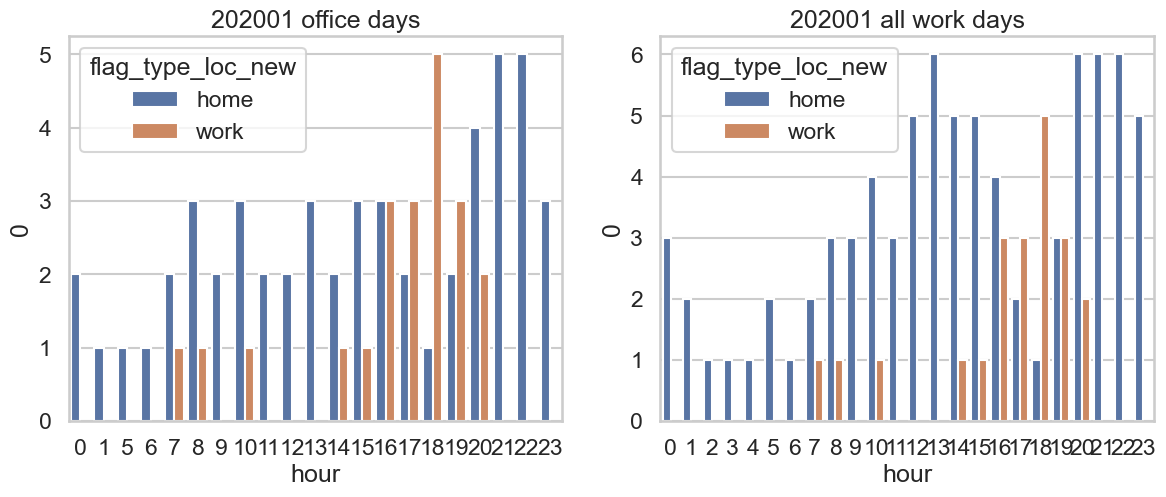

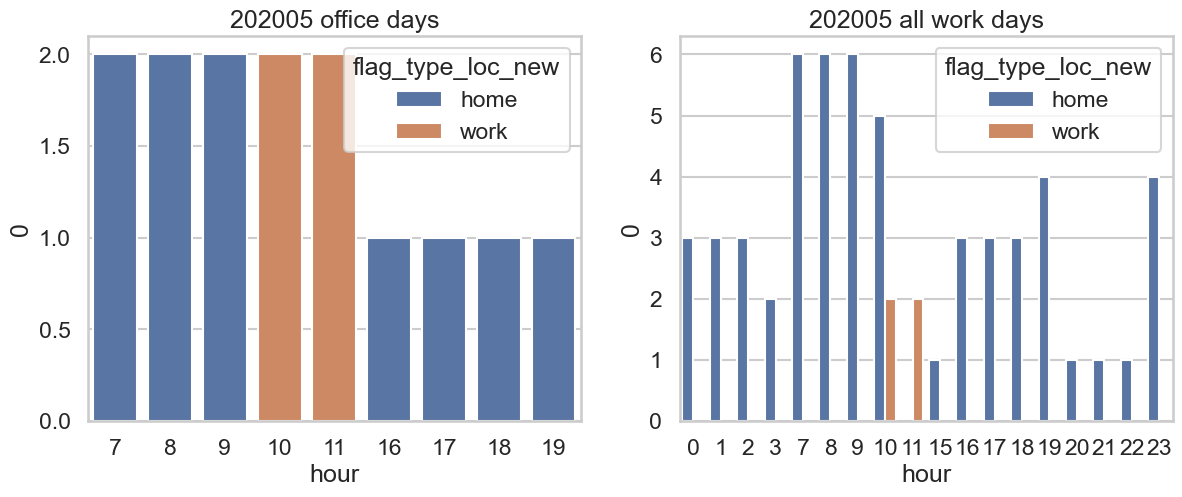

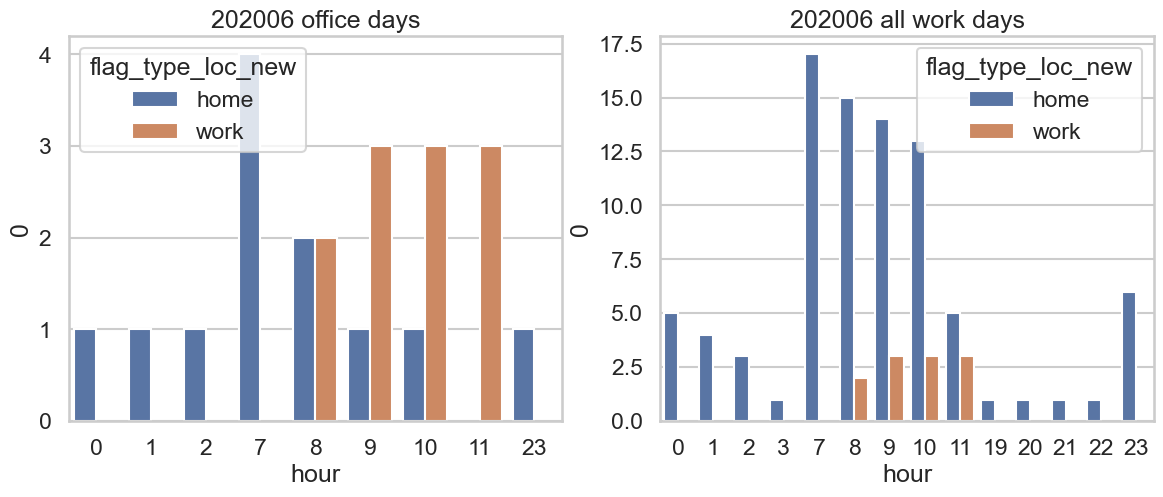

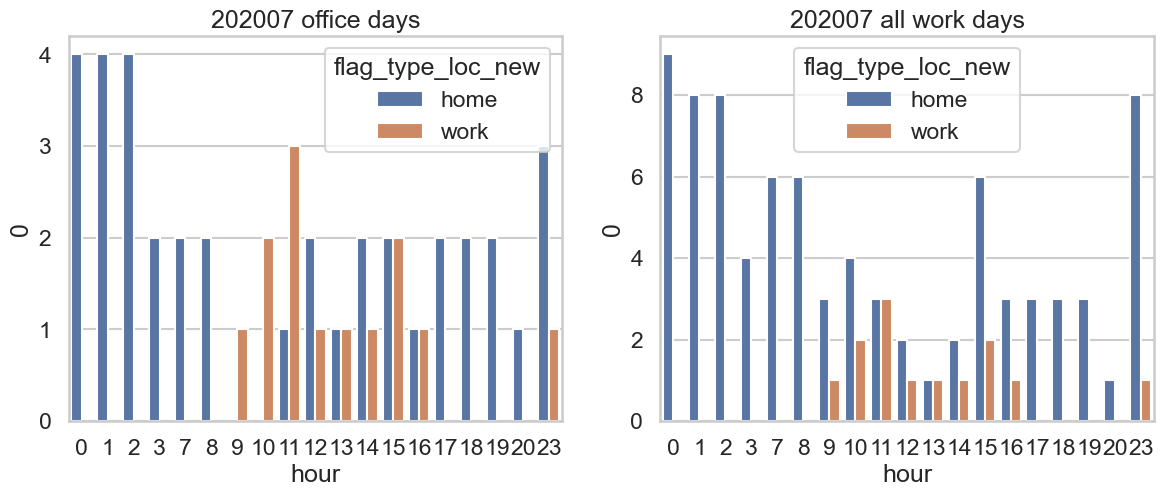

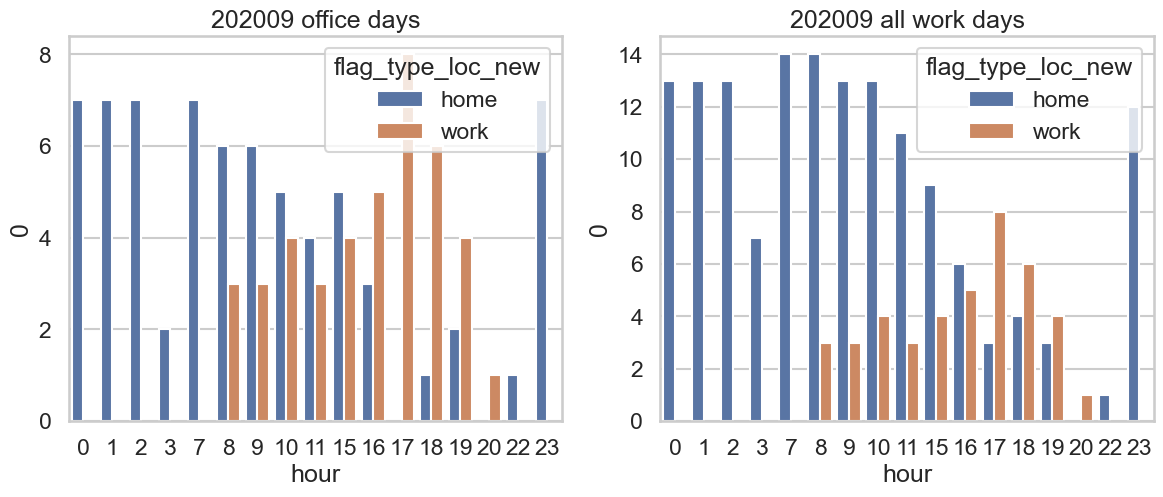

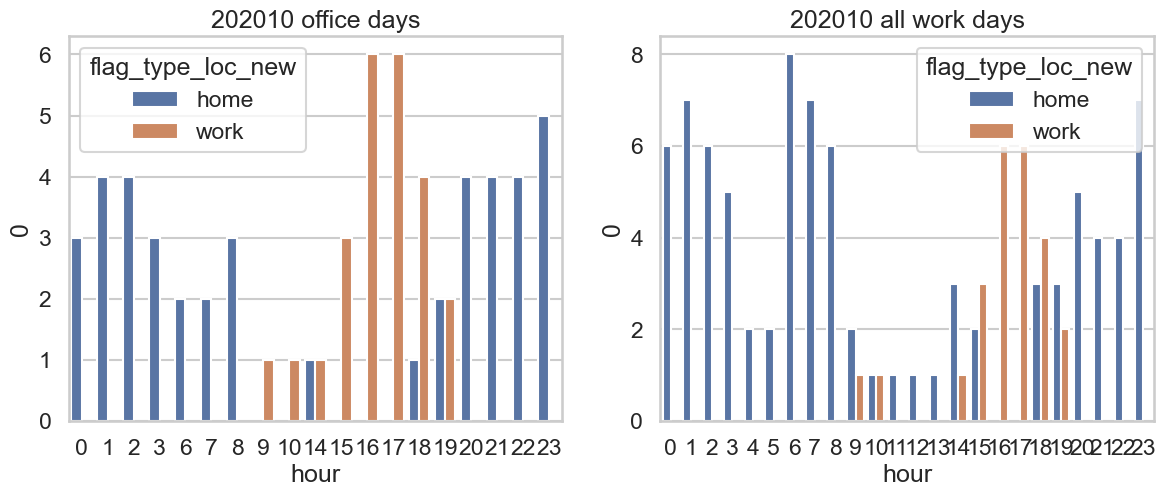

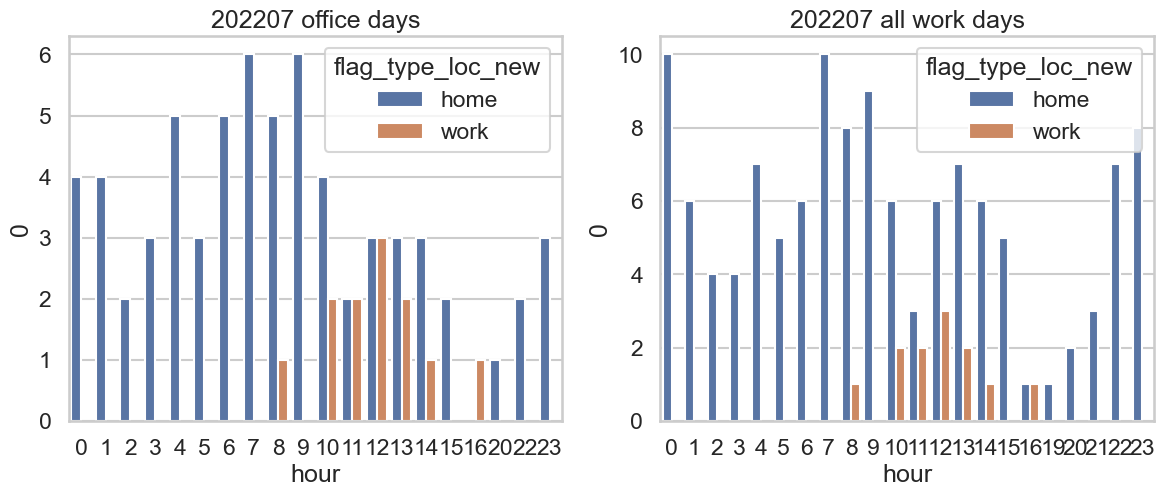

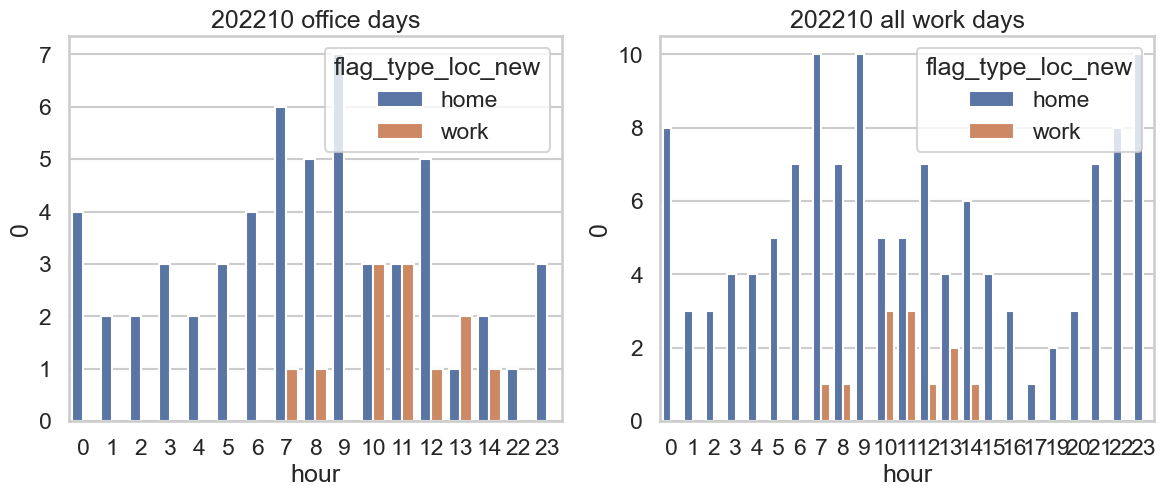

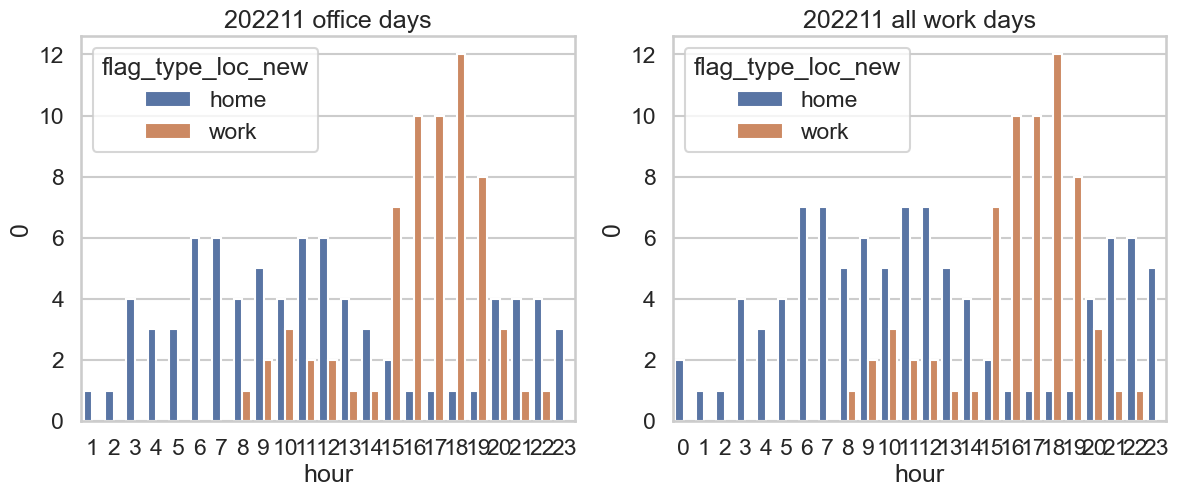

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn

for MONTH in months:
    df_month_loc_hours_office = (
        df_hours[
            (df_hours["identifier"] == ident)
            & (df_hours.month == MONTH)
            & (df_hours["office_day"])
            & (~df_hours.flag_weekend)
        ]
        .groupby(["hour", "flag_type_loc_new"])
        .size()
        .reset_index()
    )
    df_month_loc_hours = (
        df_hours[
            (df_hours["identifier"] == ident)
            & (df_hours.month == MONTH)
            & (~df_hours.flag_weekend)
        ]
        .groupby(["hour", "flag_type_loc_new"])
        .size()
        .reset_index()
    )
    if len(df_month_loc_hours_office) > 0:
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))
        sn.barplot(
            data=df_month_loc_hours_office,
            x="hour",
            y=0,
            hue="flag_type_loc_new",
            ax=axs[0],
        )
        axs[1].set_title(f"{MONTH} all work days")
        sn.barplot(
            data=df_month_loc_hours, x="hour", y=0, hue="flag_type_loc_new", ax=axs[1]
        )
        axs[0].set_title(f"{MONTH} office days")
        plt.show()

In [ ]:
df_hours_one_user = df_hours[df_hours.identifier == ident]

## Conditional probability to be at work location in specific hour
* P(A/B) = (P(A)*P(B/A))/P(B)
* P(A) - share of office location hours in office day
* P(B) - share of exact hour in office_day
* P(B/A) - share of exact hour at office location in office_day

In [ ]:
prob_a = (
    df_hours_one_user[df_hours_one_user.office_day]
    .groupby(["identifier", "month"])["flag_work_geohash"]
    .mean()
    .rename("prob_office")
    .to_frame()
)
prob_b = (
    (
        df_hours_one_user[df_hours_one_user.office_day]
        .groupby(["identifier", "month", "hour"])
        .size()
        / df_hours_one_user[df_hours_one_user.office_day]
        .groupby(["identifier", "month"])
        .size()
    )
    .rename("prob_hour")
    .to_frame()
)

In [ ]:
prob_ba = (
    (
        df_hours_one_user[
            (df_hours_one_user.office_day) & (df_hours_one_user["flag_work_geohash"])
        ]
        .groupby(["identifier", "month", "hour"])
        .size()
        / df_hours_one_user[
            (df_hours_one_user.office_day) & (df_hours_one_user["flag_work_geohash"])
        ]
        .groupby(["identifier", "month"])
        .size()
    )
    .rename("prob_hour_at_office")
    .to_frame()
)

In [ ]:
df_prob = prob_b.join(prob_a, how="left").join(prob_ba, how="left").fillna(0)

In [ ]:
df_prob["prob_office_athour"] = (
    df_prob["prob_hour_at_office"] * df_prob["prob_office"] / df_prob["prob_hour"]
)

In [ ]:
df_prob = df_prob.reset_index()

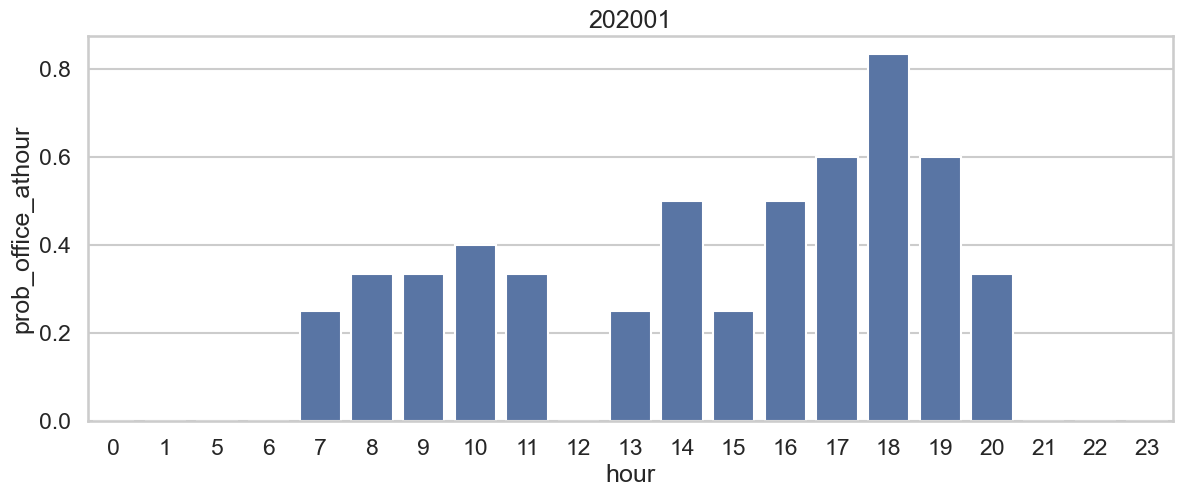

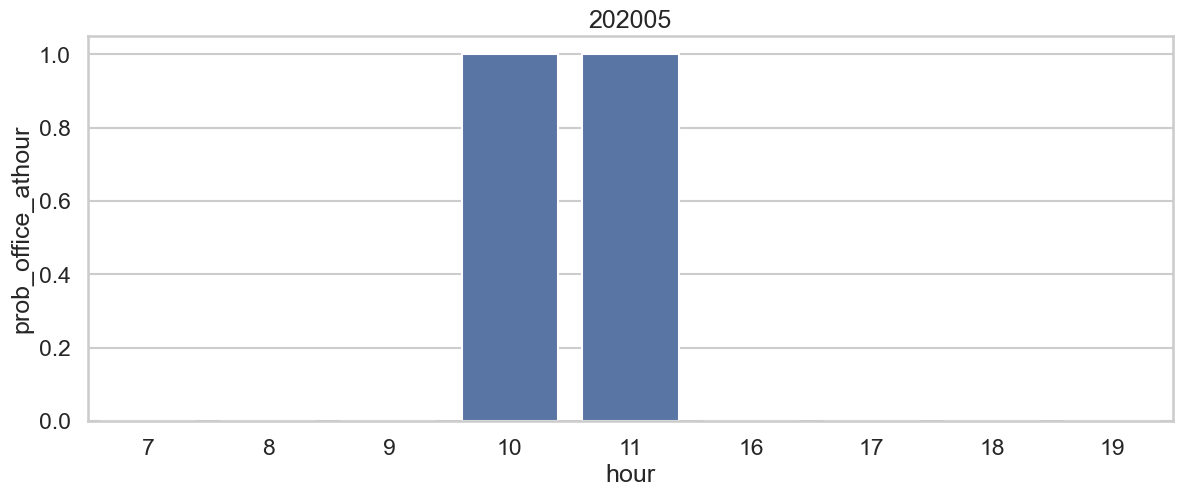

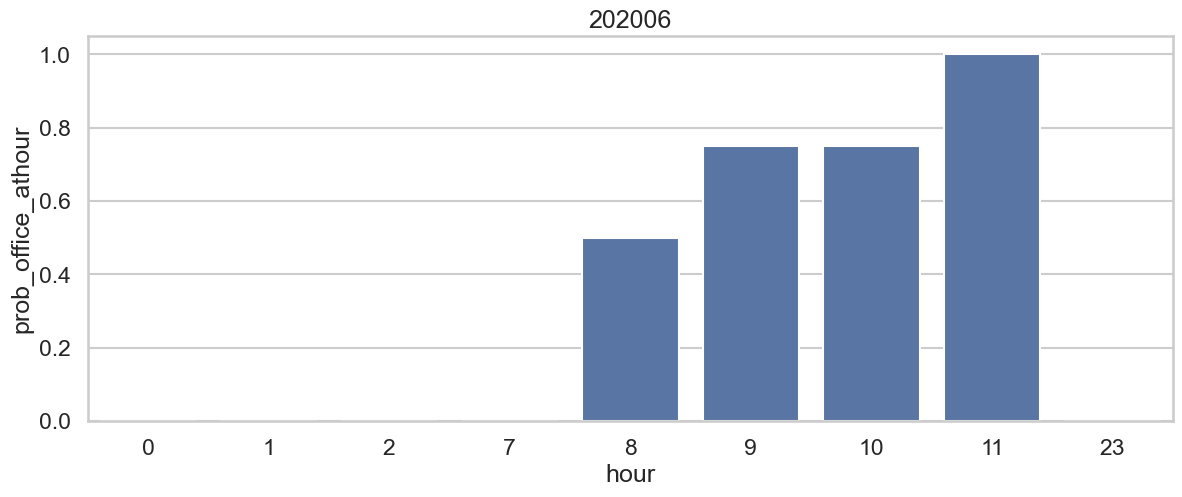

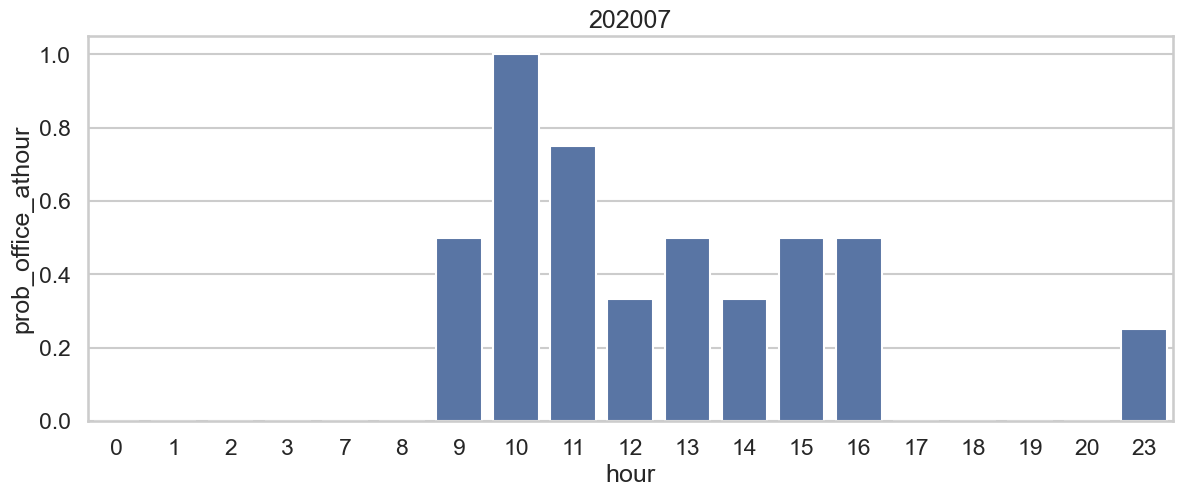

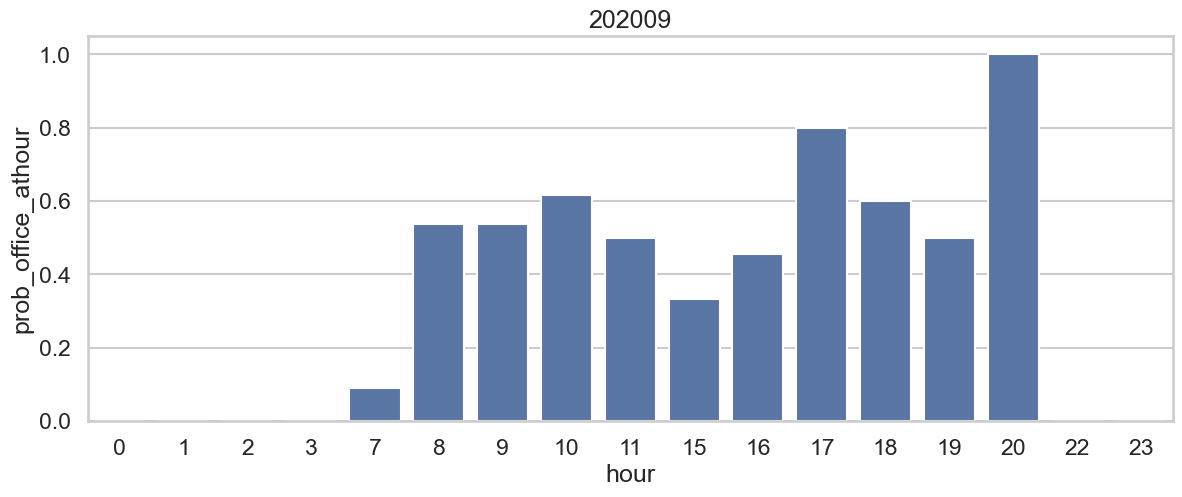

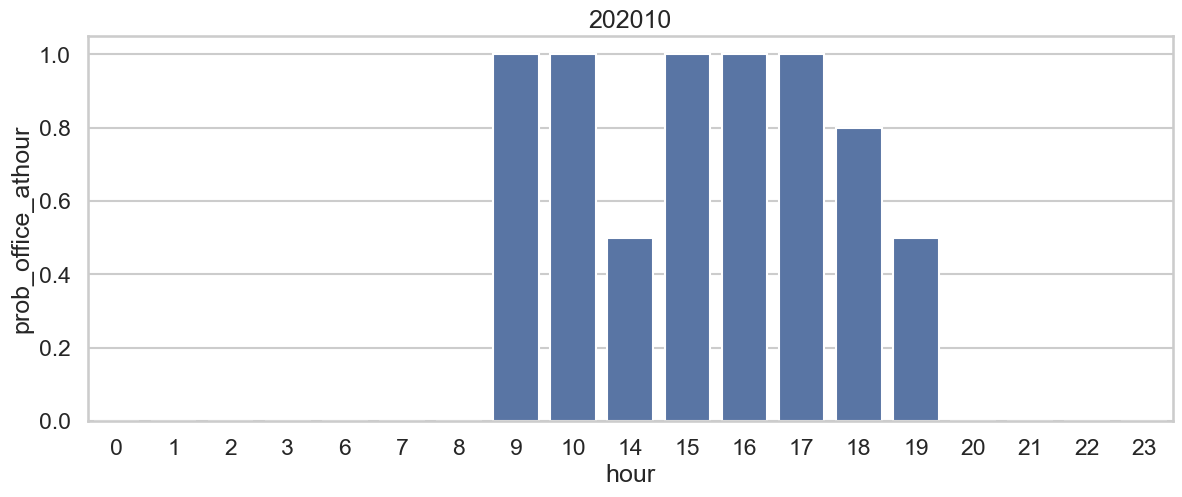

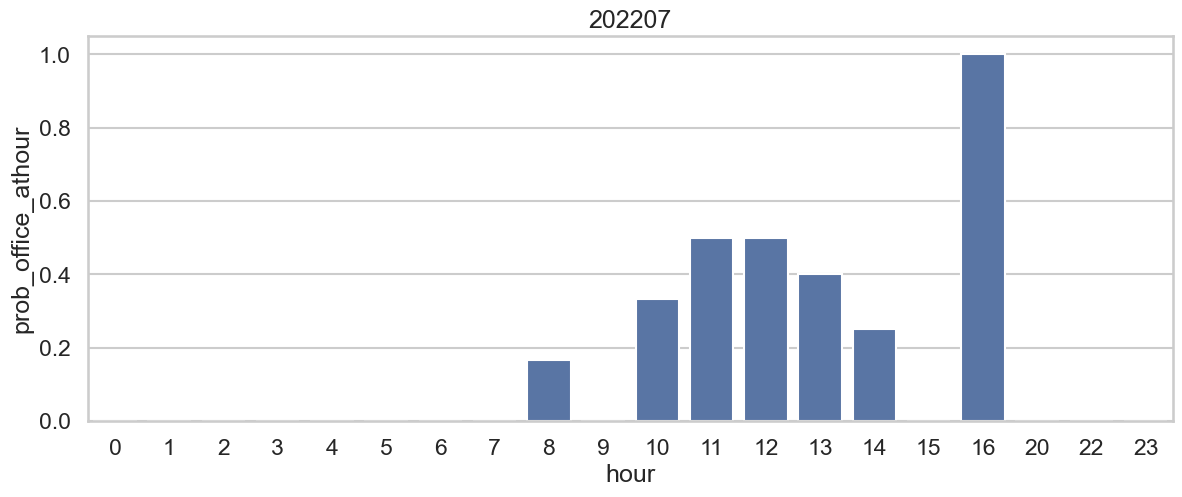

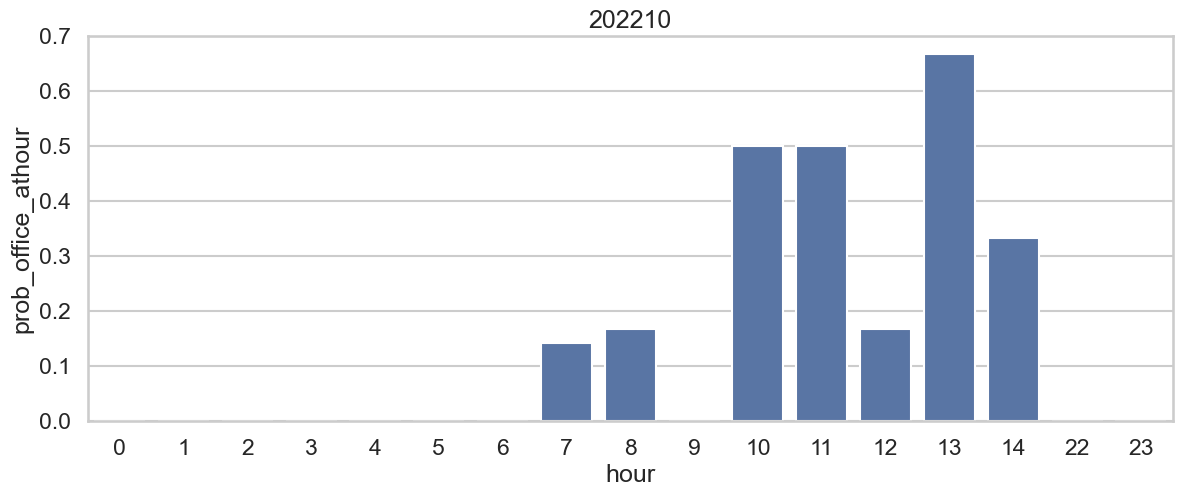

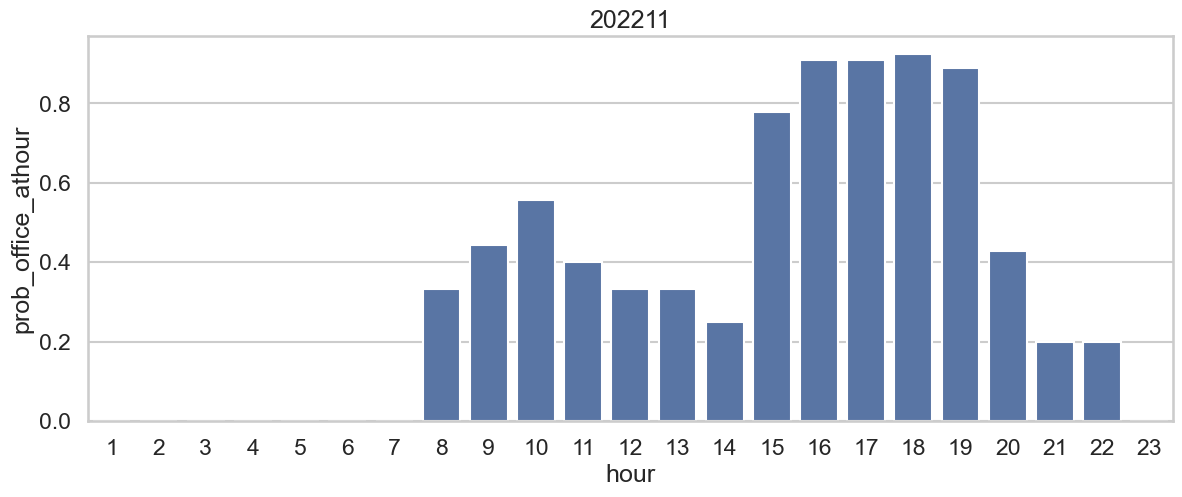

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn

for MONTH in months:
    if len(df_prob[df_prob.month == MONTH]) > 0:
        fig, axs = plt.subplots(1, 1, figsize=(14, 5))
        sn.barplot(
            data=df_prob[df_prob.month == MONTH],
            x="hour",
            y="prob_office_athour",
            ax=axs,
        )
        plt.title(MONTH)
        plt.show()

## Conditional probability to be at home location in specific hour
* P(A/B) = (P(A)*P(B/A))/P(B)
* P(A) - share of home hours in office days 
* P(B) - share of exact hour in office days 
* P(B/A) - share of exact hour at home location in office days 

In [294]:
prob_a_home = (
    df_hours_one_user[df_hours_one_user.office_day]
    .groupby(["identifier", "month"])["flag_home_geohash"]
    .mean()
    .rename("prob_home")
    .to_frame()
)

In [295]:
prob_ba_home = (
    (
        df_hours_one_user[
            (df_hours_one_user.office_day) & (df_hours_one_user["flag_home_geohash"])
        ]
        .groupby(["identifier", "month", "hour"])
        .size()
        / df_hours_one_user[
            (df_hours_one_user.office_day) & (df_hours_one_user["flag_home_geohash"])
        ]
        .groupby(["identifier", "month"])
        .size()
    )
    .rename("prob_hour_at_home")
    .to_frame()
)

In [ ]:
df_prob_home = (
    prob_b.join(prob_a_home, how="left").join(prob_ba_home, how="left").fillna(0)
)

In [ ]:
df_prob_home["prob_home_at_hour"] = (
    df_prob_home["prob_hour_at_home"]
    * df_prob_home["prob_home"]
    / df_prob_home["prob_hour"]
)

In [299]:
df_prob_home = df_prob_home.reset_index()

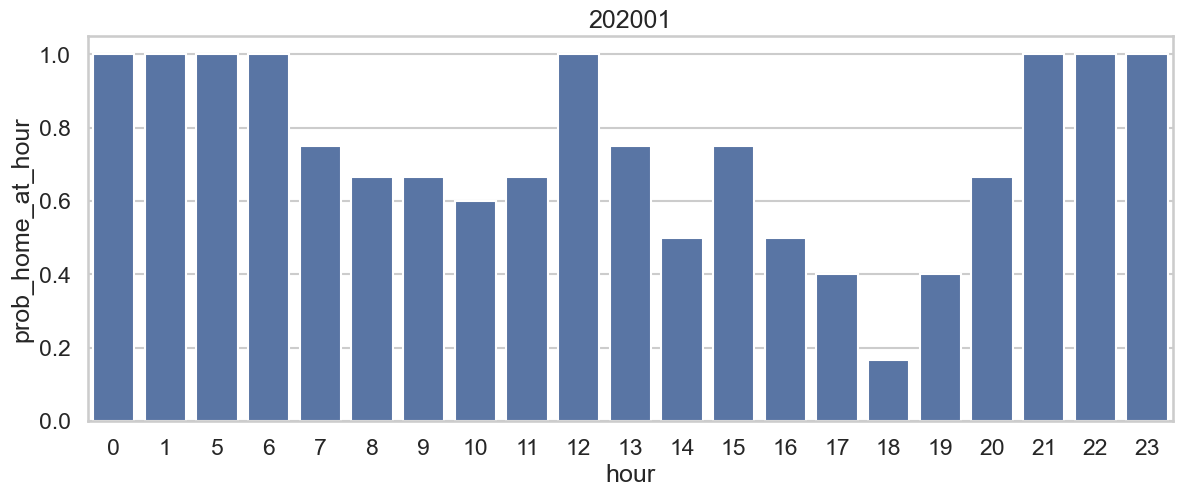

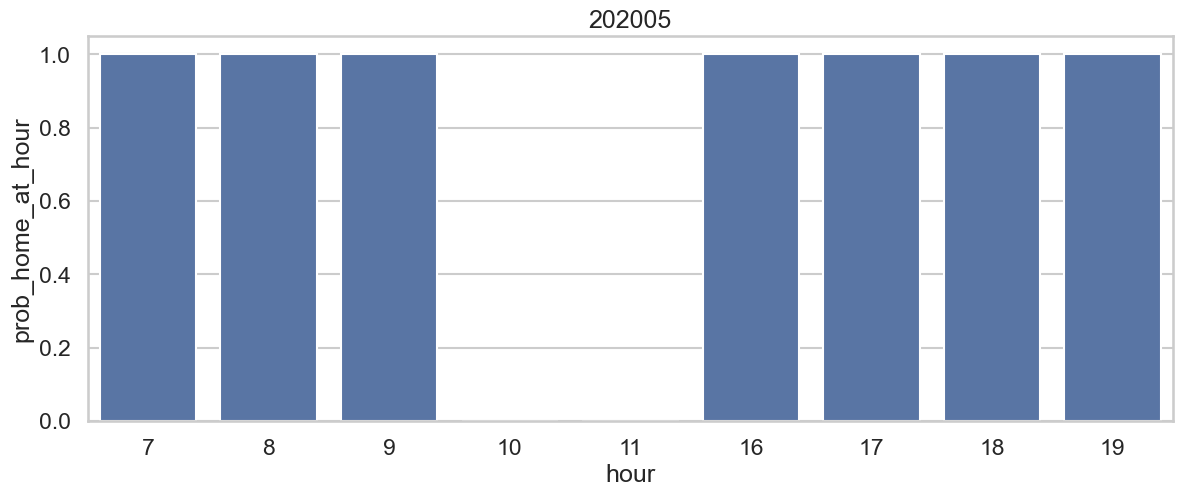

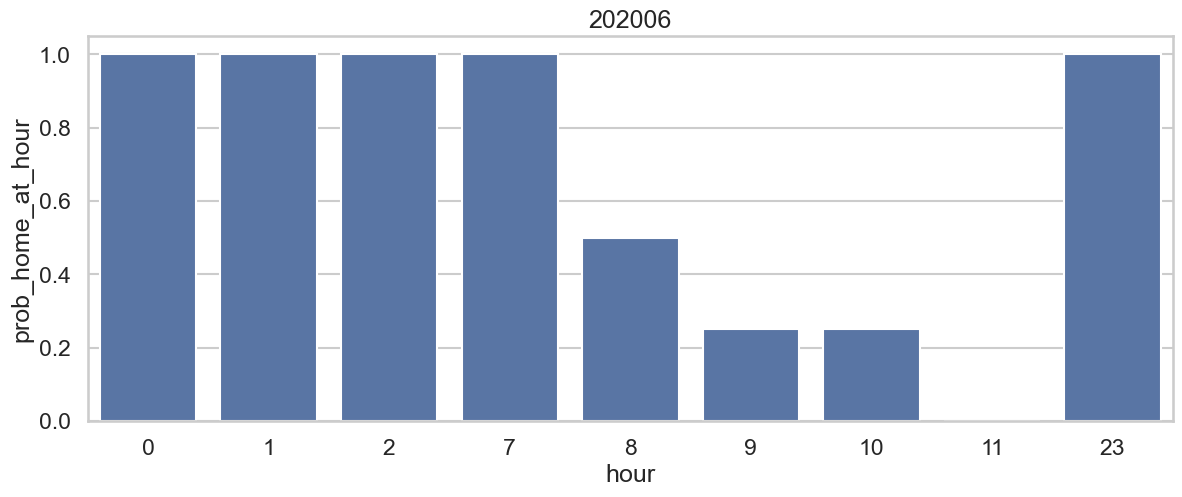

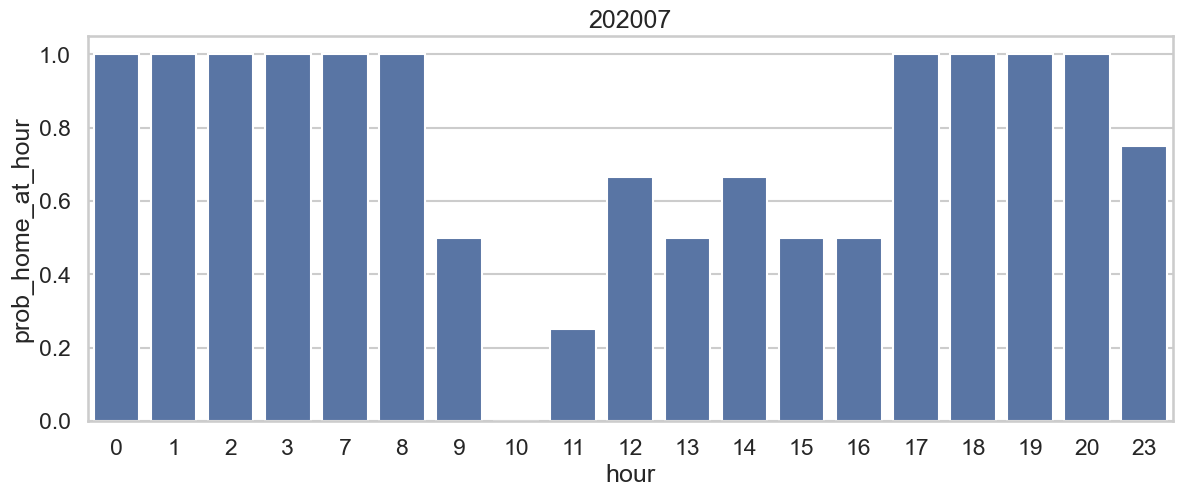

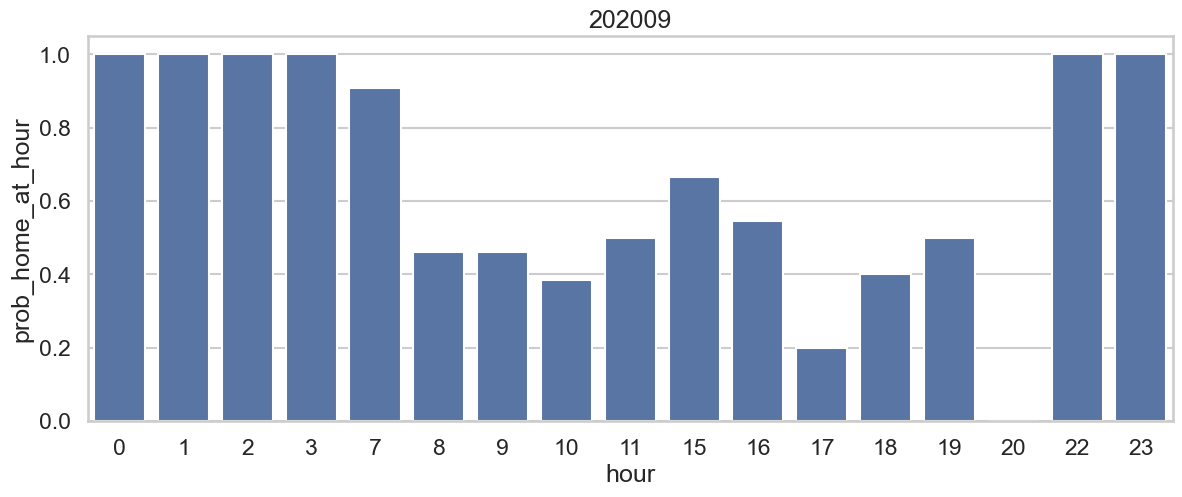

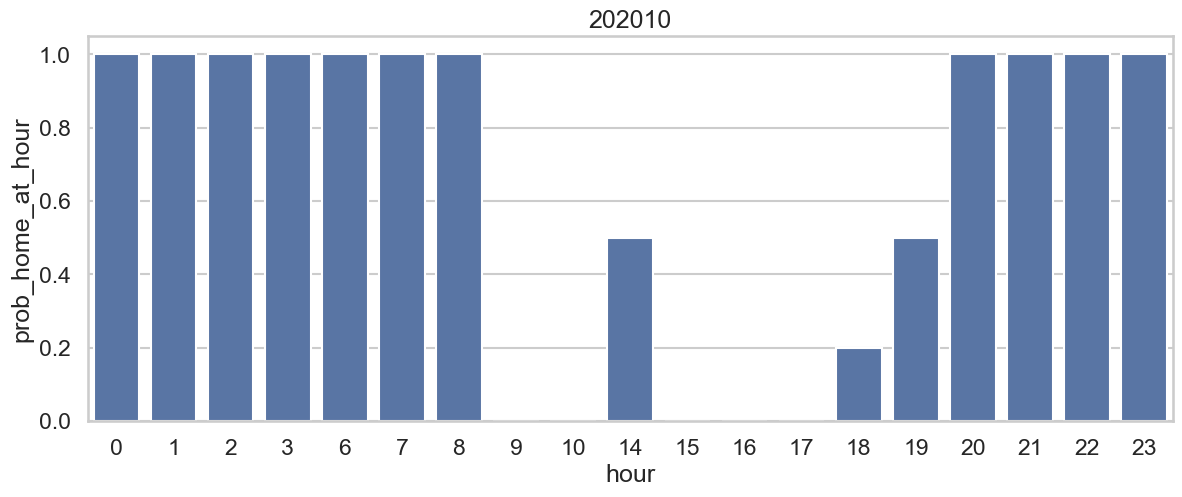

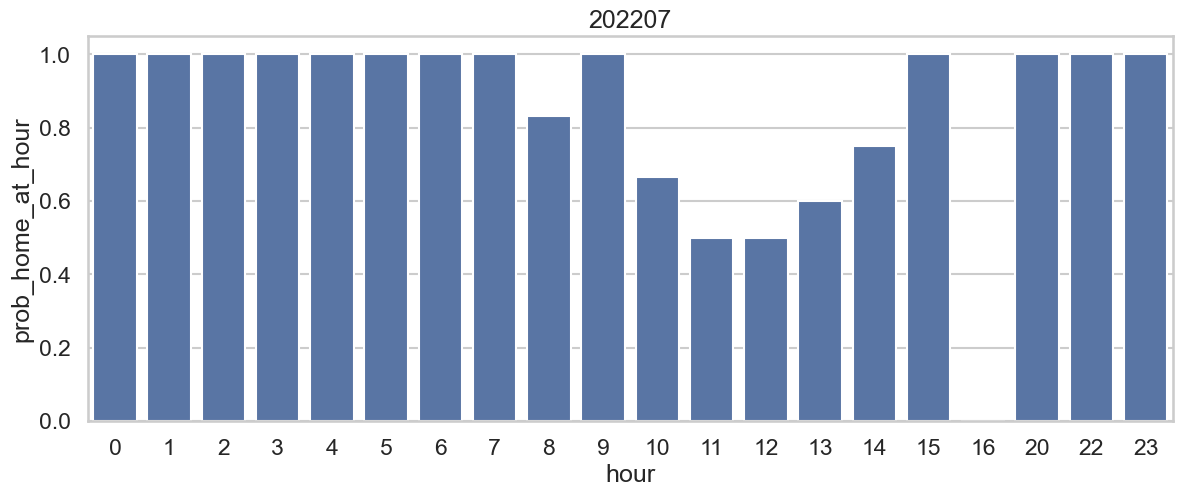

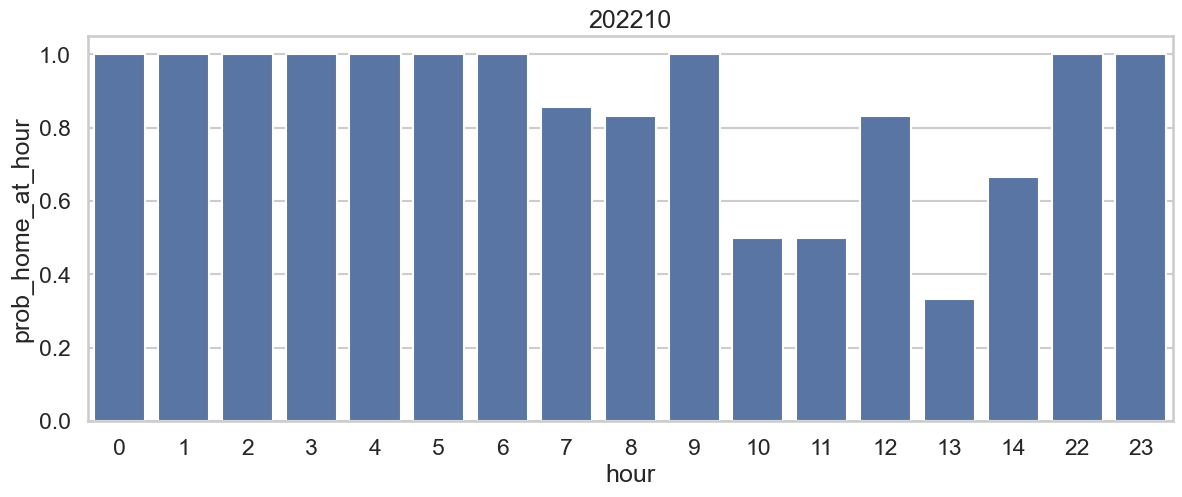

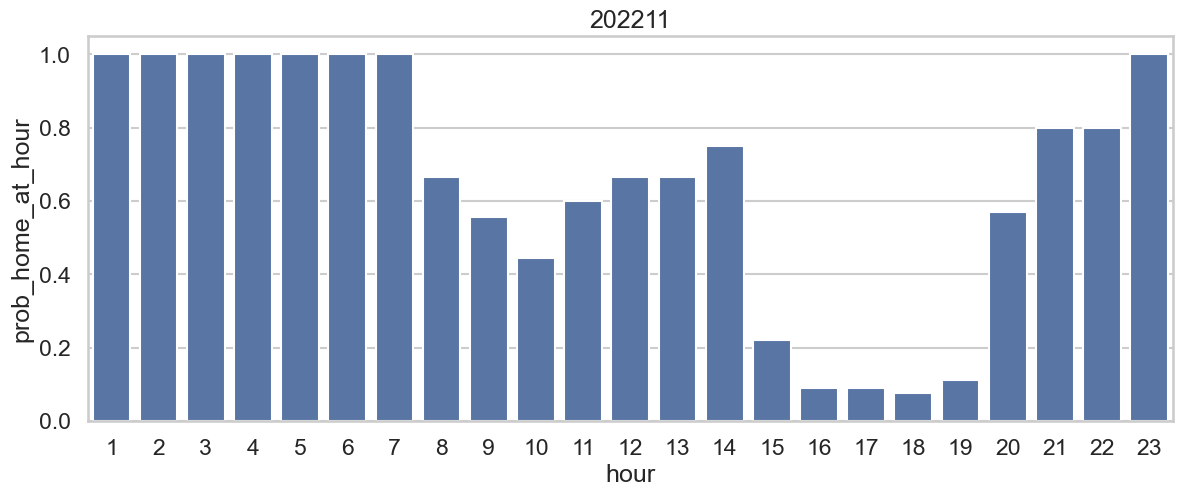

In [301]:
from matplotlib import pyplot as plt
import seaborn as sn

for MONTH in months:
    if len(df_prob_home[df_prob_home.month == MONTH]) > 0:
        fig, axs = plt.subplots(1, 1, figsize=(14, 5))
        sn.barplot(
            data=df_prob_home[df_prob_home.month == MONTH],
            x="hour",
            y="prob_home_at_hour",
            ax=axs,
        )
        plt.title(MONTH)
        plt.show()

In [ ]:
df_prob = df_prob.merge(df_prob_home, on=["identifier", "hour", "month", "prob_hour"])

## Approach I. Based on minimum probability of remote working during the day

### Multiply with curve: 0 between 20 and 8 am,  1 between 8 and 20  

In [ ]:
df_prob["expected_prob_office_hourly"] = df_prob["prob_office_athour"] * df_prob[
    "hour"
].apply(lambda x: x >= 8 and x <= 20)

In [ ]:
df_prob["flag_weekend"] = False

In [ ]:
df_hours_one_user = df_hours_one_user.merge(
    df_prob[
        ["identifier", "month", "hour", "flag_weekend", "expected_prob_office_hourly"]
    ],
    on=["identifier", "month", "hour", "flag_weekend"],
    how="left",
).fillna(0)

In [ ]:
df_hours_one_user["remote_work_prob"] = (
    (~df_hours_one_user["office_day"])
    * df_hours_one_user["expected_prob_office_hourly"]
    * df_hours_one_user["flag_home_geohash"]
)

In [ ]:
# df_hours_one_user =df_hours_one_user.merge(
#     df_hours_one_user[
#         (df_hours_one_user["office_day"]) & (df_hours_one_user.flag_work_geohash)
#     ]
#     .groupby(["identifier", "month"])["hour"]
#     .nunique()
#     .rename("work_hours_length")
#     .to_frame(),
#     on=["identifier", "month"],
# )

In [ ]:
df_hours_one_user[(df_hours_one_user.month == "202001")].groupby(
    ["identifier", "month", "date"]
)["remote_work_prob"].max()

identifier                            month   date      
35877402-7e02-48a2-a522-a9e7fe4699d8  202001  2020-01-01    0.00
                                              2020-01-02    0.00
                                              2020-01-03    0.00
                                              2020-01-04    0.00
                                              2020-01-05    0.00
                                              2020-01-06    0.00
                                              2020-01-07    0.00
                                              2020-01-12    0.00
                                              2020-01-13    0.60
                                              2020-01-14    0.00
                                              2020-01-15    0.00
                                              2020-01-16    0.40
                                              2020-01-17    0.00
                                              2020-01-18    0.00
                                 

In [ ]:
df_hours_one_user[(df_hours_one_user.month == "202005")].groupby(
    ["identifier", "month", "date", "flag_weekend"]
)["remote_work_prob"].max()

identifier                            month   date        flag_weekend
35877402-7e02-48a2-a522-a9e7fe4699d8  202005  2020-05-16  True            0.0
                                              2020-05-17  False           1.0
                                              2020-05-18  False           0.0
                                              2020-05-19  False           0.0
                                              2020-05-20  False           1.0
                                              2020-05-21  False           1.0
                                              2020-05-22  True            0.0
                                              2020-05-23  True            0.0
                                              2020-05-24  False           1.0
                                              2020-05-25  False           1.0
                                              2020-05-26  False           0.0
                                              2020-05-27  False        

In [ ]:
df_hours_one_user[(df_hours_one_user.month == "202009")].groupby(
    ["identifier", "month", "date", "flag_weekend"]
)["remote_work_prob"].max()

identifier                            month   date        flag_weekend
35877402-7e02-48a2-a522-a9e7fe4699d8  202009  2020-09-01  False           0.615385
                                              2020-09-02  False           0.000000
                                              2020-09-03  False           0.800000
                                              2020-09-04  True            0.000000
                                              2020-09-06  False           0.000000
                                              2020-09-07  False           0.000000
                                              2020-09-08  False           0.615385
                                              2020-09-09  False           0.800000
                                              2020-09-10  False           0.000000
                                              2020-09-11  True            0.000000
                                              2020-09-12  True            0.000000
                

In [ ]:
df_hours_one_user[(df_hours_one_user.month == "202211")].groupby(
    ["identifier", "month", "date", "flag_weekend"]
)["remote_work_prob"].max()

identifier                            month   date        flag_weekend
35877402-7e02-48a2-a522-a9e7fe4699d8  202211  2022-11-03  False           0.400000
                                              2022-11-06  False           0.000000
                                              2022-11-07  False           0.000000
                                              2022-11-08  False           0.000000
                                              2022-11-09  False           0.000000
                                              2022-11-10  False           0.000000
                                              2022-11-11  True            0.000000
                                              2022-11-13  False           0.000000
                                              2022-11-14  False           0.000000
                                              2022-11-15  False           0.000000
                                              2022-11-16  False           0.000000
                

In [ ]:
df_days_one_user_remote = (
    df_hours_one_user.groupby(["identifier", "month", "date"])["remote_work_prob"]
    .max()
    .reset_index()
)
df_days_one_user_remote["flag_day_remote_work"] = (
    df_days_one_user_remote["remote_work_prob"] >= 0.3
)

## Merge with original day types

In [ ]:
df_user_days = df_user_days.merge(
    df_days_one_user_remote, on=["identifier", "month", "date"]
)

In [ ]:
df_user_days["flag_day_remote_work"] = df_user_days["remote_work_prob"] >= 0.3

In [283]:
df_user_days["day_type"] = df_user_days[
    ["flag_day_remote_work", "flag_weekend", "office_day"]
].apply(
    lambda r: (
        "office"
        if r["office_day"] == 1
        else (
            "remote"
            if (r["flag_day_remote_work"] > 0) and (not r["flag_weekend"])
            else ("weekend" if r["flag_weekend"] else "unknown")
        )
    ),
    axis=1,
)

In [284]:
df_days_types_one = (
    df_user_days.groupby(["month", "day_type"]).size().rename("day_count").reset_index()
)

In [285]:
df_days_types_one.day_type.value_counts()

day_type
office     9
remote     9
weekend    9
unknown    8
Name: count, dtype: int64

In [286]:
months = df_days_types_one["month"].unique()
day_types = df_days_types_one["day_type"].unique()

# Create a complete DataFrame with all combinations of months and day types
full_combinations = pd.MultiIndex.from_product(
    [months, day_types], names=["month", "day_type"]
)
full_df = pd.DataFrame(index=full_combinations).reset_index()
df_days_types_complete = full_df.merge(
    df_days_types_one, on=["month", "day_type"], how="left"
).fillna({"day_count": 0})

In [287]:
df_days_types_complete["day_count"] = df_days_types_complete["day_count"].astype(int)

In [288]:
df_days_types_complete.isnull().mean()

month        0.0
day_type     0.0
day_count    0.0
dtype: float64

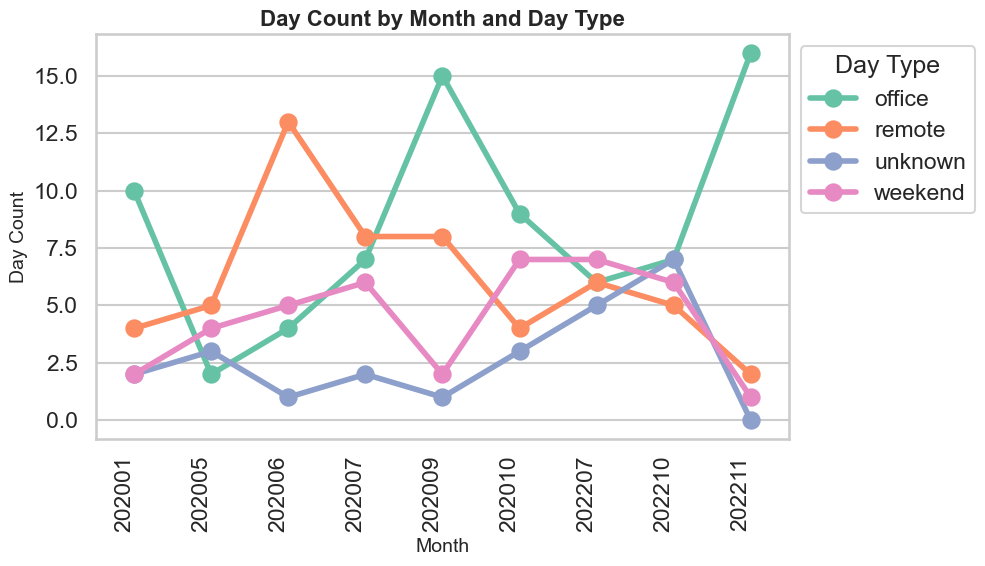

In [289]:
import seaborn as sn
import matplotlib.pyplot as plt

# Set the style and context
sn.set_theme(style="whitegrid", context="talk")


# Create the point plot with enhancements
plt.figure(figsize=(10, 6))
plot = sn.pointplot(
    data=df_days_types_complete,
    x="month",
    y="day_count",
    hue="day_type",
    palette="Set2",  # Vibrant color palette
)

# Customize labels and title
plot.set_title("Day Count by Month and Day Type", fontsize=16, weight="bold")
plot.set_xlabel("Month", fontsize=14)
plot.set_ylabel("Day Count", fontsize=14)

# Rotate x-axis labels for better readability
plot.set_xticklabels(
    plot.get_xticklabels(), rotation="vertical", horizontalalignment="right"
)

# Add legend and improve its placement
plot.legend(title="Day Type", loc="upper left", bbox_to_anchor=(1, 1))


# Display the plot
plt.tight_layout()
plt.show()

In [290]:
# Exclude rows where day_type is 'Weekend'
filtered_df = df_days_types_complete[df_days_types_complete["day_type"] != "weekend"]

# Calculate the total day count per month (excluding 'Weekend')
filtered_df["month_total"] = filtered_df.groupby("month")["day_count"].transform("sum")

# Calculate the share of day counts for each row
filtered_df["share_of_day_counts"] = (
    filtered_df["day_count"] / filtered_df["month_total"]
)

# Drop the temporary 'month_total' column if not needed
filtered_df = filtered_df.drop(columns=["month_total"])

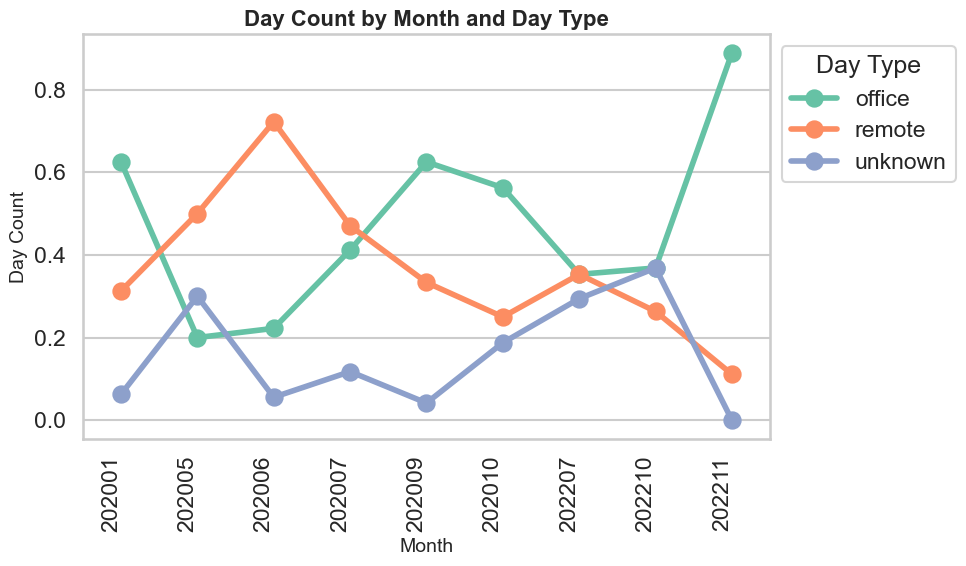

In [280]:
import seaborn as sn
import matplotlib.pyplot as plt

# Set the style and context
sn.set_theme(style="whitegrid", context="talk")


# Create the point plot with enhancements
plt.figure(figsize=(10, 6))
plot = sn.pointplot(
    data=filtered_df,
    x="month",
    y="share_of_day_counts",
    hue="day_type",
    palette="Set2",  # Vibrant color palette
)

# Customize labels and title
plot.set_title("Day Count by Month and Day Type", fontsize=16, weight="bold")
plot.set_xlabel("Month", fontsize=14)
plot.set_ylabel("Day Count", fontsize=14)

# Rotate x-axis labels for better readability
plot.set_xticklabels(
    plot.get_xticklabels(), rotation="vertical", horizontalalignment="right"
)

# Add legend and improve its placement
plot.legend(title="Day Type", loc="upper left", bbox_to_anchor=(1, 1))


# Display the plot
plt.tight_layout()
plt.show()

# Approach 2. Choose the highest probability of being at home or at work

In [ ]:
df_hours_one_user = df_hours_one_user.merge(
    df_prob[
        [
            "identifier",
            "month",
            "hour",
            "flag_weekend",
            "prob_office_athour",
            "prob_office_athour",
        ]
    ],
    on=["identifier", "month", "hour", "flag_weekend"],
    how="left",
).fillna(0)
df_hours_one_user["flag_remote_work"] = (
    (~df_hours_one_user["office_day"])
    * (df_hours_one_user["prob_home_at_hour"] < df_hours_one_user["prob_office_athour"])
    * df_hours_one_user["flag_home_geohash"]
)

In [ ]:
df_hours_one_user.groupby(["identifier", "month", "date"])[
    "flag_remote_work"
].max().groupby(["identifier", "month"]).sum() / df_hours_one_user[
    ~df_hours_one_user.flag_weekend
].groupby(
    ["identifier", "month"]
)[
    "date"
].nunique()

identifier                            month 
35877402-7e02-48a2-a522-a9e7fe4699d8  202001    0.071429
                                      202005    0.500000
                                      202006    0.722222
                                      202007    0.250000
                                      202009    0.400000
                                      202010    0.250000
                                      202207    0.058824
                                      202210    0.210526
                                      202211    0.062500
dtype: float64

## This gives us commuting frequency so I like it more

<Axes: xlabel='month'>

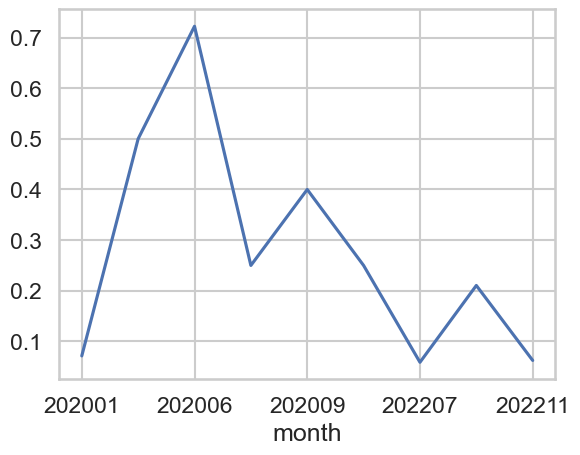

In [ ]:
(
    df_hours_one_user.groupby(["month", "date"])["flag_remote_work"]
    .max()
    .groupby(["month"])
    .sum()
    / df_hours_one_user[~df_hours_one_user.flag_weekend]
    .groupby(["month"])["date"]
    .nunique()
).plot()

Check why January 2020 have high "remote work" level

In [ ]:
df_hours_one_user[
    (df_hours_one_user.month == "202001") & (~df_hours_one_user.office_day)
][
    [
        "identifier",
        "month",
        "date",
        "hour",
        "office_day",
        "flag_home_geohash",
        "remote_work_prob",
        "expected_prob_office_hourly",
    ]
].sort_values(
    ["date", "hour"]
).head(
    70
)

,identifier,month,date,hour,office_day,flag_home_geohash,remote_work_prob,expected_prob_office_hourly
1,35877402-7e02-48a2-a522-a9e7fe4699d8,202001,2020-01-04,15,False,True,0.000000,0.000000
2,35877402-7e02-48a2-a522-a9e7fe4699d8,202001,2020-01-04,16,False,True,0.000000,0.000000
3,35877402-7e02-48a2-a522-a9e7fe4699d8,202001,2020-01-04,17,False,True,0.000000,0.000000
4,35877402-7e02-48a2-a522-a9e7fe4699d8,202001,2020-01-04,18,False,True,0.000000,0.000000
84,35877402-7e02-48a2-a522-a9e7fe4699d8,202001,2020-01-04,20,False,True,0.000000,0.000000
85,35877402-7e02-48a2-a522-a9e7fe4699d8,202001,2020-01-04,21,False,True,0.000000,0.000000
43,35877402-7e02-48a2-a522-a9e7fe4699d8,202001,2020-01-13,0,False,True,0.000000,0.000000
44,35877402-7e02-48a2-a522-a9e7fe4699d8,202001,2020-01-13,1,False,True,0.000000,0.000000
100,35877402-7e02-48a2-a522-a9e7fe4699d8,202001,2020-01-13,12,False,True,0.000000,0.000000
101,35877402-7e02-48a2-a522-a9e7fe4699d8,202001,2020-01-13,13,False,True,0.250000,0.250000


## Now we apply it to each identifier

In [ ]:
def return_prob_a(location_type, df_hours):
    if location_type == "work":
        name = "prob_office"
    else:
        name = "prob_home"
    prob_a = (
        df_hours[df_hours.office_day]
        .groupby(["identifier", "month"])[f"flag_{location_type}_geohash"]
        .mean()
        .rename(name)
        .to_frame()
    )
    return prob_a


def return_prob_ba(location_type, df_hours):
    if location_type == "work":
        name = "prob_hour_at_office"
    else:
        name = "prob_hour_at_home"
    prob_ba = (
        (
            df_hours[
                (df_hours.office_day) & (df_hours[f"flag_{location_type}_geohash"])
            ]
            .groupby(["identifier", "month", "hour"])
            .size()
            / df_hours[
                (df_hours.office_day) & (df_hours[f"flag_{location_type}_geohash"])
            ]
            .groupby(["identifier", "month"])
            .size()
        )
        .rename(name)
        .to_frame()
    )
    return prob_ba


def conditional_probability_table(df_hours):
    prob_a_work = return_prob_a("work", df_hours)
    prob_a_home = return_prob_a("home", df_hours)
    prob_b = (
        (
            df_hours[df_hours.office_day]
            .groupby(["identifier", "month", "hour"])
            .size()
            / df_hours[df_hours.office_day].groupby(["identifier", "month"]).size()
        )
        .rename("prob_hour")
        .to_frame()
    )
    prob_ba_work = return_prob_ba("work", df_hours)
    prob_ba_home = return_prob_ba("home", df_hours)

    df_prob = (
        prob_b.join(prob_a_work, how="left")
        .join(prob_a_home, how="left")
        .join(prob_ba_work, how="left")
        .join(prob_ba_home, how="left")
        .fillna(0)
    )
    df_prob = df_prob.reset_index()

    # Conditional probability
    df_prob["prob_office_at_hour"] = (
        df_prob["prob_hour_at_office"] * df_prob["prob_office"] / df_prob["prob_hour"]
    )

    # remove unrealistic probability for remote work
    df_prob["expected_prob_office_hour"] = df_prob["prob_office_at_hour"] * df_prob[
        "hour"
    ].apply(lambda x: x >= 8 and x <= 20)

    df_prob["prob_home_at_hour"] = (
        df_prob["prob_hour_at_home"] * df_prob["prob_home"] / df_prob["prob_hour"]
    )

    df_prob["flag_weekend"] = False

    return df_prob

In [364]:
df_prob_full = conditional_probability_table(df_hours)

In [365]:
df_prob_full.head(2)

,identifier,month,hour,prob_hour,prob_office,prob_home,prob_hour_at_office,prob_hour_at_home,prob_office_at_hour,expected_prob_office_hour,prob_home_at_hour,flag_weekend
0,004ca579-0401-4440-b3b8-1541fed7c050,202204,4,0.035714,0.571429,0.428571,0.0000,0.083333,0.0,0.0,1.0,False
1,004ca579-0401-4440-b3b8-1541fed7c050,202204,5,0.071429,0.571429,0.428571,0.0625,0.083333,0.5,0.0,0.5,False


In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn

for MONTH in months:
    if len(df_prob_full[df_prob_full.month == MONTH]) > 0:
        fig, axs = plt.subplots(1, 1, figsize=(14, 5))
        sn.barplot(
            data=df_prob_full[df_prob_full.month == MONTH]
            .groupby("hour")["prob_office_at_hour"]
            .mean()
            .reset_index(),
            x="hour",
            y="prob_office_at_hour",
            ax=axs,
        )
        sn.barplot(
            data=df_prob_full[df_prob_full.month == MONTH]
            .groupby("hour")["prob_home_at_hour"]
            .mean()
            .reset_index(),
            x="hour",
            y="prob_home_at_hour",
            ax=axs,
            color="yellow",
        )
        plt.title(MONTH)
        plt.show()

In [ ]:
df_hours = (
    df_hours.drop(
        ["expected_prob_office_hour", "prob_home_at_hour", "prob_office_at_hour"],
        axis=1,
    )
    .merge(
        df_prob_full[
            [
                "identifier",
                "month",
                "hour",
                "flag_weekend",
                "expected_prob_office_hour",
                "prob_home_at_hour",
                "prob_office_at_hour",
            ]
        ],
        on=["identifier", "month", "hour", "flag_weekend"],
        how="left",
    )
    .fillna(0)
)

In [368]:
# 1st approach. Based on remote work probability
df_hours["remote_work_probability"] = (
    (~df_hours["office_day"])
    * df_hours["expected_prob_office_hour"]
    * df_hours["flag_home_geohash"]
)
# 2nd approach. Based on comparing probability for home and office
df_hours["flag_remote_work_comparison"] = (
    (~df_hours["office_day"])
    * (df_hours["prob_home_at_hour"] < df_hours["prob_office_at_hour"])
    * df_hours["flag_home_geohash"]
)

In [ ]:
df_hours = df_hours.drop("flag_remote_work", axis=1)

In [370]:
# df_hours.groupby(["identifier", "month", "date"])[
#     "flag_remote_work"
# ].max().groupby(["identifier", "month"]).sum() / df_hours[
#     ~df_hours.flag_weekend
# ].groupby(
#     ["identifier", "month"]
# )[
#     "date"
# ].nunique()

In [571]:
df_hours.columns

Index(['identifier', 'identifier_type', 'timestamp', 'local_date_time',
       'province', 'classification', 'duration_seconds', 'centroid_latitude',
       'centroid_longitude', 'bump_count', 'potential_start_time',
       'potential_end_time', 'month', 'the_geom', 'frequency',
       'duration_hours', 'geohash', 'date', 'start_date_time', 'end_date_time',
       'flag_night', 'flag_work_hours', 'geohash_home', 'geohash_work',
       'geometry_work', 'distance_work', 'flag_work_geohash', 'geometry_home',
       'distance_home', 'flag_home_geohash', 'flag_type_loc_new',
       'hours_in_interval', 'hour', 'flag_weekend', 'work_location_hours',
       'office_day', 'flag_work_hour', 'flag_work_hours_day',
       'remote_work_probability', 'flag_remote_work_comparison',
       'expected_prob_office_hour', 'prob_home_at_hour',
       'prob_office_at_hour'],
      dtype='object')

In [388]:
df_days_remote = (
    df_hours.groupby(["identifier", "month", "date"])[
        ["remote_work_probability", "flag_remote_work_comparison"]
    ]
    .max()
    .reset_index()
)
df_days_remote["flag_remote_work_min_prob"] = (
    df_days_remote["remote_work_probability"] >= 0.3
)

In [527]:
df_days_remote = df_days_remote.drop('flag_work_hours_day', axis=1).merge(df_hours
            .groupby(["identifier", "month","date"])['flag_work_hours_day'].max(), on = ["identifier", "month","date"])

In [ ]:
# df_days_remote = df_days_remote.merge(
#     df_hours[~df_hours.flag_weekend]
#     .groupby(["identifier", "month"])["date"]
#     .nunique()
#     .rename("nonweekends_count"),
#     on=["identifier", "month"],
# )

In [568]:
 df_days_remote.head()

,identifier,month,date,remote_work_probability,flag_remote_work_comparison,flag_remote_work_min_prob,flag_work_hours_day
0,004ca579-0401-4440-b3b8-1541fed7c050,202204,2022-04-05,0.0,False,False,True
1,004ca579-0401-4440-b3b8-1541fed7c050,202204,2022-04-06,0.0,False,False,True
2,004ca579-0401-4440-b3b8-1541fed7c050,202204,2022-04-10,0.0,False,False,True
3,004ca579-0401-4440-b3b8-1541fed7c050,202204,2022-04-15,0.0,False,False,False
4,004ca579-0401-4440-b3b8-1541fed7c050,202204,2022-04-25,0.0,False,False,False


In [529]:
df_monthly_remote = (
    df_days_remote.groupby(["identifier","month"])[
        [
            "flag_remote_work_min_prob",
            "remote_work_probability",
            "flag_remote_work_comparison",
        ]
    ]
    .mean()
    .join(
        (
            df_days_remote.groupby(["identifier", "month"])[
                "flag_remote_work_comparison"
            ].sum()
            /df_days_remote.groupby(["identifier", "month"])['flag_work_hours_day']
            .sum()
        ).rename("share_remote_work_comparison_days")
    )
    .join(
        (
            df_days_remote.groupby(["identifier", "month"])[
                "flag_remote_work_min_prob"
            ].sum()
            /df_days_remote.groupby(["identifier", "month"])['flag_work_hours_day']
            .sum()
        ).rename("share_remote_work_min_prob_days")
    )
)

In [530]:
df_monthly_remote = df_monthly_remote.sort_values('month')

In [531]:
df_days_remote[ df_days_remote.identifier=='d86f85c6-4063-40eb-a293-26763ea712ac'].groupby(["identifier", "month"])[
                "flag_remote_work_comparison"
            ].sum()

identifier                            month 
d86f85c6-4063-40eb-a293-26763ea712ac  202001    1
                                      202005    1
                                      202007    0
                                      202009    3
                                      202101    0
                                      202104    0
                                      202203    2
                                      202204    0
                                      202207    2
                                      202302    5
Name: flag_remote_work_comparison, dtype: int64

<Axes: xlabel='month'>

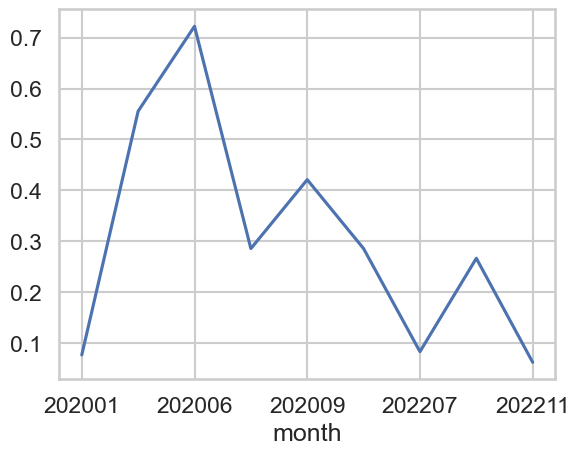

In [535]:
df_monthly_remote.loc[ident]['share_remote_work_comparison_days'].plot()

In [505]:
(
    df_hours_one_user.groupby(["month", "date"])["flag_remote_work"]
    .max()
    .groupby(["month"])
    .sum()
    / df_hours_one_user[~df_hours_one_user.flag_weekend]
    .groupby(["month"])["date"]
    .nunique()
)

month
202001    0.071429
202005    0.500000
202006    0.722222
202007    0.250000
202009    0.400000
202010    0.250000
202207    0.058824
202210    0.210526
202211    0.062500
dtype: float64

In [537]:
df_monthly_remote.reset_index()[df_monthly_remote.reset_index().identifier==ident]['share_remote_work_comparison_days']

7        0.076923
1473     0.555556
2215     0.722222
2807     0.285714
5407     0.421053
6280     0.285714
9618     0.083333
11196    0.266667
11582    0.062500
Name: share_remote_work_comparison_days, dtype: float64

In [536]:
df_monthly_remote = df_monthly_remote.reset_index()

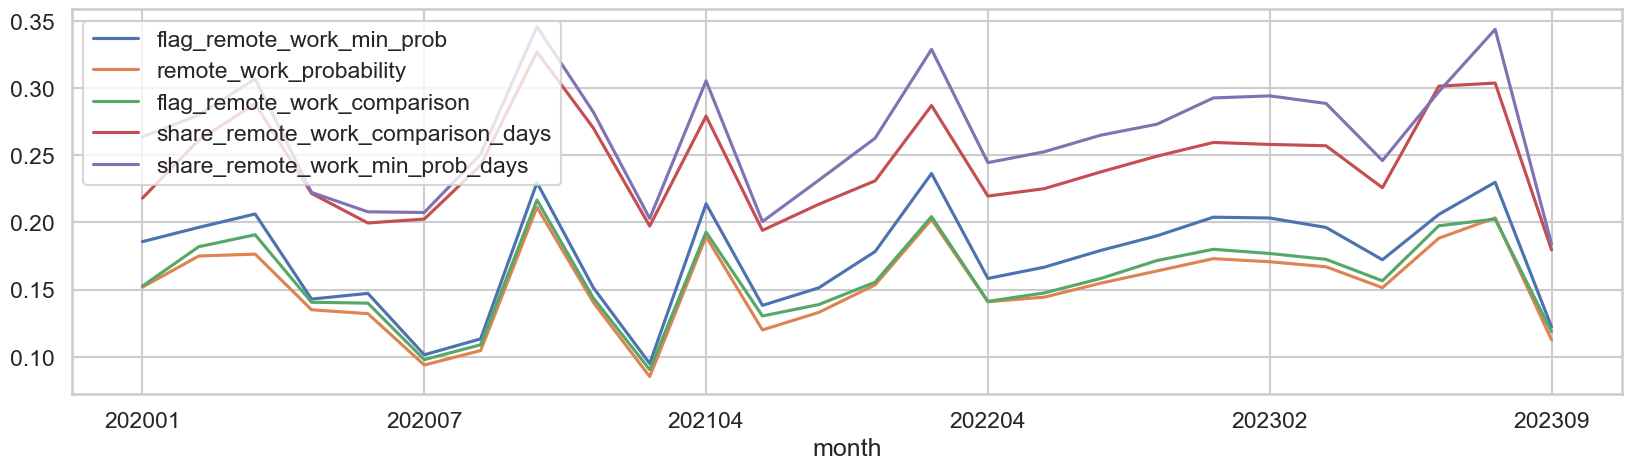

In [560]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
df_monthly_remote.groupby('month')[['flag_remote_work_min_prob',
       'remote_work_probability', 'flag_remote_work_comparison',
       'share_remote_work_comparison_days', 'share_remote_work_min_prob_days']].mean().plot(ax=ax);

In [421]:
df_monthly_remote.loc[df_monthly_remote.month=='202007']

,identifier,month,flag_remote_work_min_prob,remote_work_probability,flag_remote_work_comparison,share_remote_work_comparison_days,share_remote_work_min_prob_days
2665,375b744f-437f-44a2-9eb6-ab38481c2099,202007,0.117647,0.117647,0.117647,0.142857,0.142857
2666,bfd3d409-9656-480f-8a61-59cd33d3e44c,202007,0.040000,0.040000,0.080000,0.105263,0.052632
2667,caf568e0-db0d-48a1-a78c-f912ea4d2166,202007,0.045455,0.045455,0.045455,0.058824,0.058824
2668,9d5dbfd5-4765-4ce6-85b7-82bc28b04b68,202007,0.142857,0.100000,0.142857,0.200000,0.200000
2669,77d3bbea-cb9d-4150-9134-48008f185c6e,202007,0.160000,0.106667,0.080000,0.111111,0.222222
...,...,...,...,...,...,...,...
3664,fb8a062a-914e-4782-880a-4473fe2a8bdf,202007,0.000000,0.000000,0.000000,0.000000,0.000000
3665,5aca2aca-cef4-4a36-bed5-a13defed09a3,202007,0.090909,0.090909,0.090909,0.125000,0.125000
3666,d872e83d-182a-4618-98a0-b3e0a6e377a5,202007,0.055556,0.027778,0.000000,0.000000,0.083333
3667,5a86990a-eb6e-45a1-9c41-5577b06a5d52,202007,0.250000,0.222222,0.250000,0.333333,0.333333


In [425]:
df_days_remote[df_days_remote.identifier=='375b744f-437f-44a2-9eb6-ab38481c2099']

,identifier,month,date,remote_work_probability,flag_remote_work_comparison,flag_remote_work_min_prob
71990,375b744f-437f-44a2-9eb6-ab38481c2099,202006,2020-06-02,1.0,True,True
71991,375b744f-437f-44a2-9eb6-ab38481c2099,202006,2020-06-04,0.0,False,False
71992,375b744f-437f-44a2-9eb6-ab38481c2099,202006,2020-06-05,0.0,False,False
71993,375b744f-437f-44a2-9eb6-ab38481c2099,202006,2020-06-06,0.0,False,False
71994,375b744f-437f-44a2-9eb6-ab38481c2099,202006,2020-06-07,0.0,False,False
...,...,...,...,...,...,...
72113,375b744f-437f-44a2-9eb6-ab38481c2099,202301,2023-01-18,0.0,False,False
72114,375b744f-437f-44a2-9eb6-ab38481c2099,202301,2023-01-19,0.0,False,False
72115,375b744f-437f-44a2-9eb6-ab38481c2099,202301,2023-01-20,0.0,False,False
72116,375b744f-437f-44a2-9eb6-ab38481c2099,202301,2023-01-21,0.0,False,False


## Merge with original day types

In [543]:
df_user_days = (
    df_hours.groupby(["identifier", "date", "month"])[
        ["flag_work_hours_day", "flag_weekend", "office_day"]
    ]
    .mean()
    .reset_index()
)
df_user_days = df_user_days.merge(
    df_days_remote, on=["identifier", "month", "date"]
)

In [544]:
df_user_days["day_type"] = df_user_days[
    ['flag_remote_work_comparison',	'flag_remote_work_min_prob', "flag_weekend", "office_day"]
].apply(
    lambda r: (
        "office"
        if r["office_day"] == 1
        else (
            "remote"
            if (r["flag_remote_work_comparison"] > 0) and (not r["flag_weekend"])
            else ("weekend" if r["flag_weekend"] else "unknown")
        )
    ),
    axis=1,
)

In [567]:
df_days_types = (
    df_user_days.groupby(["month", "day_type"]).size().rename("day_count").reset_index()
)

In [546]:
df_days_types.day_type.value_counts()

day_type
office     26
remote     26
unknown    26
weekend    26
Name: count, dtype: int64

In [547]:
months = df_days_types["month"].unique()
day_types = df_days_types["day_type"].unique()

# Create a complete DataFrame with all combinations of months and day types
full_combinations = pd.MultiIndex.from_product(
    [months, day_types], names=["month", "day_type"]
)
full_df = pd.DataFrame(index=full_combinations).reset_index()
df_days_types_complete = full_df.merge(
    df_days_types, on=["month", "day_type"], how="left"
).fillna({"day_count": 0})

In [548]:
df_days_types_complete["day_count"] = df_days_types_complete["day_count"].astype(int)

In [549]:
# Exclude rows where day_type is 'Weekend'
filtered_df = df_days_types_complete[df_days_types_complete["day_type"] != "weekend"]

# Calculate the total day count per month (excluding 'Weekend')
filtered_df["month_total"] = filtered_df.groupby("month")["day_count"].transform("sum")

# Calculate the share of day counts for each row
filtered_df["share_of_day_counts"] = (
    filtered_df["day_count"] / filtered_df["month_total"]
)

# Drop the temporary 'month_total' column if not needed
filtered_df = filtered_df.drop(columns=["month_total"])

In [562]:
bad_months = filtered_df[(filtered_df.day_type=='unknown')&(filtered_df['share_of_day_counts']>0.32)]['month']

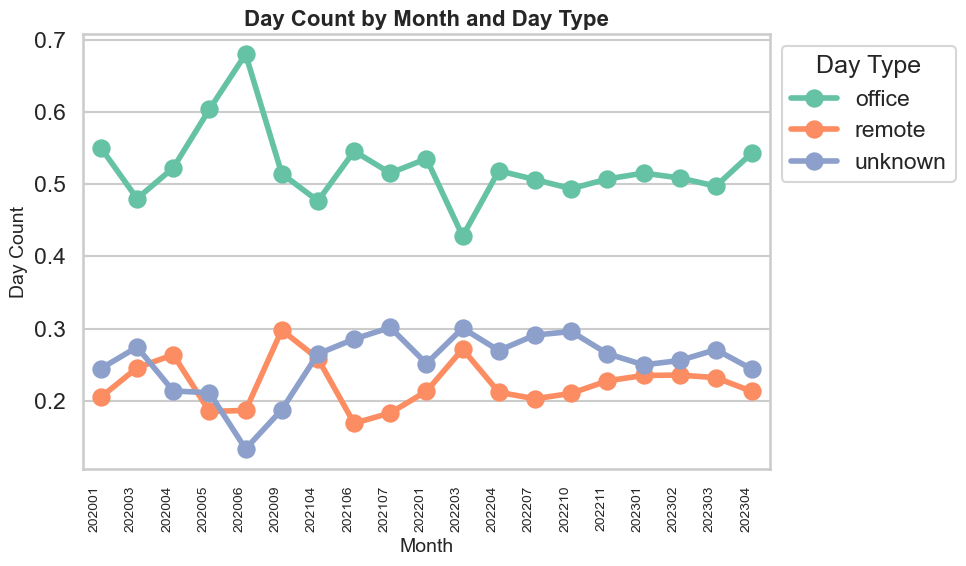

In [563]:
import seaborn as sn
import matplotlib.pyplot as plt

# Set the style and context
sn.set_theme(style="whitegrid", context="talk")


# Create the point plot with enhancements
plt.figure(figsize=(10, 6))
plot = sn.pointplot(
    data=filtered_df[~filtered_df.month.isin(bad_months)],
    x="month",
    y="share_of_day_counts",
    hue="day_type",
    palette="Set2",  # Vibrant color palette
)

# Customize labels and title
plot.set_title("Day Count by Month and Day Type", fontsize=16, weight="bold")
plot.set_xlabel("Month", fontsize=14)
plot.set_ylabel("Day Count", fontsize=14)

# Rotate x-axis labels for better readability
plot.set_xticklabels(
    plot.get_xticklabels(), rotation="vertical", horizontalalignment="right", fontsize=10
)

# Add legend and improve its placement
plot.legend(title="Day Type", loc="upper left", bbox_to_anchor=(1, 1))


# Display the plot
plt.tight_layout()
plt.show()

In [465]:
df_monthly_remote[~df_monthly_remote.month.isin(bad_months)].columns

Index(['identifier', 'month', 'flag_remote_work_min_prob',
       'remote_work_probability', 'flag_remote_work_comparison',
       'share_remote_work_comparison_days', 'share_remote_work_min_prob_days'],
      dtype='object')

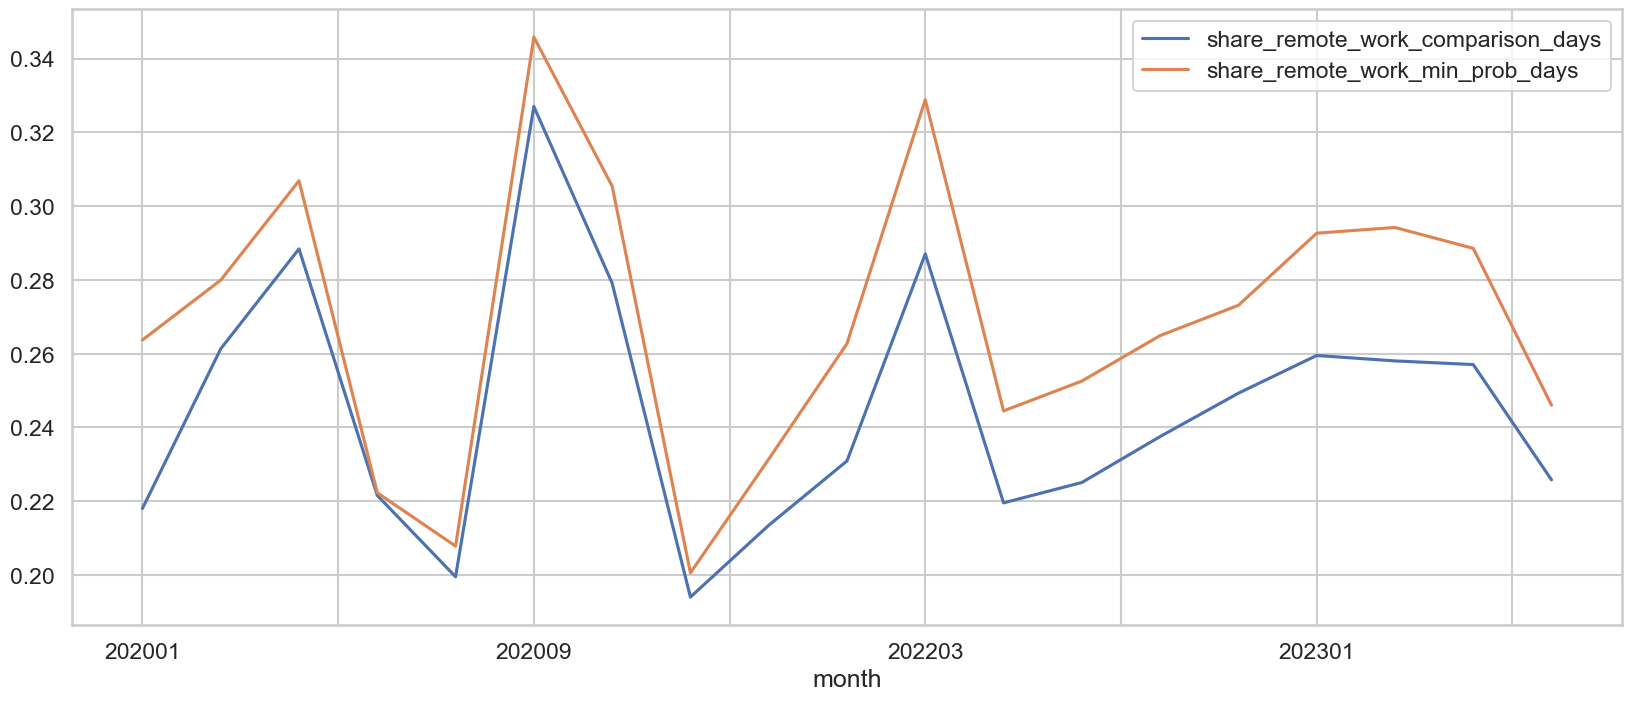

In [564]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
df_monthly_remote[~df_monthly_remote.month.isin(bad_months)].groupby('month')[[
       'share_remote_work_comparison_days', 'share_remote_work_min_prob_days']].mean().plot(ax=ax);

In [469]:
df_monthly_remote[df_monthly_remote.month=='202106'].head(2)

,identifier,month,flag_remote_work_min_prob,remote_work_probability,flag_remote_work_comparison,share_remote_work_comparison_days,share_remote_work_min_prob_days
8054,fe452ce8-af4a-47e3-ad7c-546c609dd03f,202106,0.000000,0.000000,0.000000,0.000000,0.000000
8055,fff83b7d-9370-4d8a-bb58-d0f40b772257,202106,0.058824,0.058824,0.058824,0.071429,0.071429


In [478]:
df_hours.columns

Index(['identifier', 'identifier_type', 'timestamp', 'local_date_time',
       'province', 'classification', 'duration_seconds', 'centroid_latitude',
       'centroid_longitude', 'bump_count', 'potential_start_time',
       'potential_end_time', 'month', 'the_geom', 'frequency',
       'duration_hours', 'geohash', 'date', 'start_date_time', 'end_date_time',
       'flag_night', 'flag_work_hours', 'geohash_home', 'geohash_work',
       'geometry_work', 'distance_work', 'flag_work_geohash', 'geometry_home',
       'distance_home', 'flag_home_geohash', 'flag_type_loc_new',
       'hours_in_interval', 'hour', 'flag_weekend', 'work_location_hours',
       'office_day', 'flag_work_hour', 'flag_work_hours_day',
       'remote_work_probability', 'flag_remote_work_comparison',
       'expected_prob_office_hour', 'prob_home_at_hour',
       'prob_office_at_hour'],
      dtype='object')

In [ ]:
df_hours[(df_hours.identifier == 'fff83b7d-9370-4d8a-bb58-d0f40b772257')&(df_hours.month=='202107')&(~df_hours.office_day)] [[
        "month",
        "date",
        "hour",
        "office_day",
        "flag_weekend",
        "flag_home_geohash",
        "flag_work_geohash",
        'prob_home_at_hour',
       'prob_office_at_hour',
        'remote_work_probability', 'flag_remote_work_comparison'
    ]
].sort_values(
    ["date", "hour"]).head(50)